# Overview

The data used here is from the 2023 CarMax Winter Analytics Showcase. It shows a series of transactions among customers who sold and purhased a used car at CarMax.

## Goals
While there are many questions to ask, I chose to focus on the sale/purchase price of used cars and predicting what these might be based on the details of the car.

This is only tangentially related to competition (which I sadly missed out on by a few weeks) objective that teams were tasked with--to determine what a customer's trade-in might predict about the car they will purchase. Overall, there are few *strong* associations between the car sold and car purchased. In my R markdown notebooks I go over a few cases where brand loyalty seems to be higher, I note that certain appraisal models have stronger correlation between appraisal offer and purchase price (I describe some of my methodology for working this in the notebooks below), etc.

However, as far as price goes, most of the information about a car's price seems to be encoded in the car itself, not in the other car the purchaser used (I explore/demonstrate this with some simple modeling in notebook 3)

One of the challenges here is that the data (columns described below) are intensely obfuscated (using non-descriptive dummy categories for things like body and uses price ranges instead of raw price). Most notably, this turns the task of predicting value from a standard regression task into an ordinal regression task.

A final goal for later on is to apply Shapley Values for model inference and develop a small dashboard with Dash/Plotly to explore those Shapley values.

In [1]:
# Wrangling/math/stats
import pandas as pd
import numpy as np
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy.stats import poisson, chi2, kendalltau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# System / Python utils
import os
from pathlib import Path
from typing import Tuple
import warnings

# Utils
from utils.data_io import load_carmax_data, carmax_short_to_long,\
    carmax_long_to_short
from utils.consts import APPRAISAL_COLS, PURCHASE_COLS
from utils.imputation import IterativeImputer
from utils.preprocessing import get_midpoint

# Get local file structure
CWD = os.getcwd()
CWD = Path(CWD)
DATA = CWD.parents[0] / "data"

# Load Data
Note that my import function renamed some of these columns and handled some explicit datatype conversions.

## Common Transaction Attributes
This field is a single column which applies to both the appraisal and the purchased vehicle.
| column name | description | obfuscated |
| ----- | ----- | ----- |
| market | An integer encoding which geographic market the car was purchased in | Yes, given a numberic code |

## Appraisal-Only Transaction Attributes
This field is a column which is only relevant to the appraisals.
| column name | description | obfuscated |
| ----- | ----- | ----- |
| onlne_appraisal_flag | Whether the appraisal was made online or not | No |

## Common Vehicle Attributes
These attributes are specific to all cars, whether they were the appraised or purchase vehicles.
*Columns followed  "_purchase" apply to the purchase vehicle* and *columns followed by "_appraisal" apply to the appraisal vehicle*.

| column name | description | obsfuscated |
| ----- | ----- | ----- | 
| value | Dollar value exchanged during transaction | Yes, listed as a range/ordinal |
| mileage | Miles driven (listed on odometer) | Yes, listed as a range/ordinal |
| make | The company that produced the car | Yes, 3-letter code |
| model | The company that produced the car | Yes, 3-letter make code + numeric ID |
| model_year | Year model was produced in | No |
| trim_descrip | Premium or non-premium interior features of car | No |
| body | The general form-factor of the car | Yes, single letter code |
| color | The color of the car | No |
| engine | Engine size in liters | No |
| cylinders | Number of engine cylinders | No |
| horsepower | Horsepower generated by engine | No |
| fuel_capacity| Fuel storage capacity of vehicle's tank | No |
| mpg_city | Average gas mileage traveling on city streets | No |
| mpg_highway | Average gas mileage traveling on the highway | No |

In [2]:
kmax_data = load_carmax_data(DATA/"ShowcaseDataWinter2023.csv")
kmax_data.to_pickle(DATA/"kmax.pkl")
kmax_data

value_purchase value_appraisal  online_appraisal_flag  \
0        $20k to $25k      $0k to $5k                    1.0   
1        $15k to $20k      $0k to $5k                    0.0   
2        $30k to $35k    $35k to $40k                    1.0   
3        $35k to $40k     $5k to $10k                    1.0   
4        $30k to $35k    $15k to $20k                    1.0   
...               ...             ...                    ...   
199995   $15k to $20k    $15k to $20k                    1.0   
199996   $20k to $25k    $10k to $15k                    0.0   
199997   $30k to $35k      $0k to $5k                    0.0   
199998   $30k to $35k    $10k to $15k                    0.0   
199999   $50k to $55k    $15k to $20k                    0.0   

        model_year_purchase  mileage_purchase make_purchase model_purchase  \
0                      2014  15k to 20k miles           HDT         HDT_12   
1                      2006       100k+ miles           KQZ         KQZ_23   
2                      2014   5k to 10k miles           CZV         CZV_10   
3                      2014  15k to 20k miles           IZA         IZA_19   
4                      2011  35k to 40k miles           HDT          HDT_8   
...                     ...               ...           ...            ...   
199995                 2013  10k to 15k miles           OFW          OFW_6   
199996                 2014  55k to 60k miles           ARU         ARU_12   
199997                 2014  10k to 15k miles           AIH         AIH_13   
199998                 2012  50k to 55k miles           KQZ          KQZ_3   
199999                 2014   5k to 10k miles           CIP         CIP_22   

       trim_descrip_purchase body_purchase color_purchase  ...  \
0                    Premium             E            Red  ...   
1                    Premium             E         Silver  ...   
2                    Premium             E          Black  ...   
3                    Premium             F         Silver  ...   
4                    Premium             F           Blue  ...   
...                      ...           ...            ...  ...   
199995               Premium             F          Black  ...   
199996           Not Premium             F          White  ...   
199997               Premium             F         Silver  ...   
199998           Not Premium             D          Black  ...   
199999               Premium             E          Black  ...   

        trim_descrip_appraisal  body_appraisal  color_appraisal  \
0                          NaN               D           Silver   
1                  Not Premium               D             Gold   
2                          NaN               E              Red   
3                      Premium               F             Blue   
4                  Not Premium               E            Black   
...                        ...             ...              ...   
199995             Not Premium               E            Black   
199996             Not Premium               B            Black   
199997             Not Premium               F             Gray   
199998                 Premium               D            White   
199999                 Premium               E             Blue   

        engine_appraisal  cylinders_appraisal  mpg_city_appraisal  \
0                    4.0                    6                17.0   
1                    4.2                    6                16.0   
2                    2.0                    4                41.0   
3                    3.0                    6                17.0   
4                    2.4                    4                20.0   
...                  ...                  ...                 ...   
199995               1.4                    4                26.0   
199996               1.8                    4                30.0   
199997               2.4                    4                21.0   
199998       

# Exploratory Analysis

We'll start with a Pandas summary, showing the datatypes (object = string) and how complete each column is.

In [3]:
kmax_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   value_purchase           200000 non-null  category
 1   value_appraisal          200000 non-null  category
 2   online_appraisal_flag    196166 non-null  float64 
 3   model_year_purchase      200000 non-null  Int64   
 4   mileage_purchase         200000 non-null  category
 5   make_purchase            200000 non-null  object  
 6   model_purchase           200000 non-null  object  
 7   trim_descrip_purchase    176159 non-null  object  
 8   body_purchase            189741 non-null  object  
 9   color_purchase           199967 non-null  object  
 10  engine_purchase          200000 non-null  float64 
 11  cylinders_purchase       200000 non-null  Int64   
 12  mpg_city_purchase        199410 non-null  float64 
 13  mpg_highway_purchase     199410 non-null  fl

## Check missing values

Next, I'll check how much of the data are actually present. In short, there are many, many missing values.

The rest of this notebook is mostly devoted to imputing these values.

In [4]:
from typing import List, Optional

def report_missing_vals(df: pd.DataFrame, subset: str = "all"):
    """
    Prints number of rows within specified columns with any missing values and returns
    table summarizing which rows have missing values.

    Args:
        df (pandas.DataFrame): The input data to check for missing values
        subset (str): A string indicating which subset of columns to check: 'purchase,'
            'appraisal,' or 'all'
    """
    subset = subset.lower()
    if subset == "purchase":
        cols = PURCHASE_COLS
    elif subset == "appraisal":
        cols = APPRAISAL_COLS
    elif subset == "all":
        cols = df.columns

    rows_with_missing = df[cols].isna().any(axis=1).sum()
    print(f"{rows_with_missing} rows with missing ({subset} columns) data remain.")

    sns.histplot(df[cols].isna().sum(axis=1))
    plt.title(f"Missing Values ({subset.capitalize()} Columns)");
    plt.show()
    plt.close()
    
    return df[cols].isna().sum().sort_values(ascending=False)

#### Overall NAs
How many rows have NAs in any column?

71317 rows with missing (all columns) data remain.


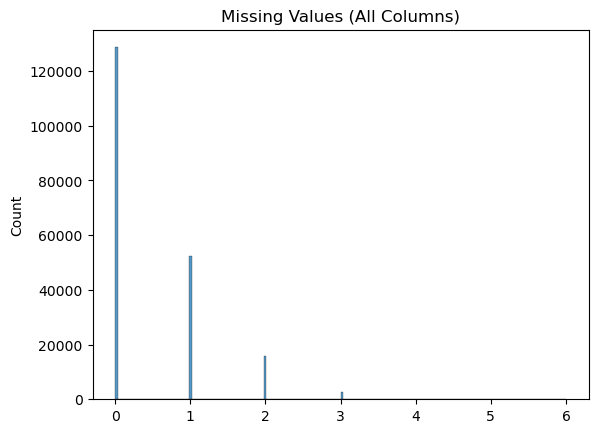

trim_descrip_appraisal     31080
trim_descrip_purchase      23841
model_appraisal            21508
body_purchase              10259
online_appraisal_flag       3834
color_appraisal             1318
mpg_city_purchase            590
mpg_highway_purchase         590
fuel_capacity_appraisal      312
color_purchase                33
fuel_capacity_purchase         4
mpg_city_appraisal             1
cylinders_appraisal            0
engine_appraisal               0
make_appraisal                 0
mpg_highway_appraisal          0
body_appraisal                 0
horsepower_appraisal           0
value_purchase                 0
mileage_appraisal              0
model_year_appraisal           0
value_appraisal                0
horsepower_purchase            0
cylinders_purchase             0
engine_purchase                0
model_purchase                 0
make_purchase                  0
mileage_purchase               0
model_year_purchase            0
market                         0
dtype: int

In [5]:
report_missing_vals(kmax_data)

#### Purchase NAs
How many rows have NAs in the core purchase columns?

32542 rows with missing (purchase columns) data remain.


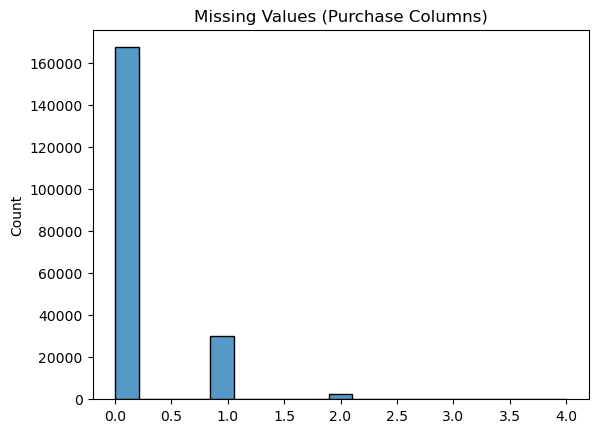

trim_descrip_purchase     23841
body_purchase             10259
mpg_city_purchase           590
mpg_highway_purchase        590
color_purchase               33
fuel_capacity_purchase        4
value_purchase                0
model_year_purchase           0
mileage_purchase              0
make_purchase                 0
model_purchase                0
engine_purchase               0
cylinders_purchase            0
horsepower_purchase           0
market                        0
dtype: int64

In [6]:
report_missing_vals(kmax_data, subset="purchase")

#### Appraisal NAs
How many rows have NAs in the appraisal columns?

49719 rows with missing (appraisal columns) data remain.


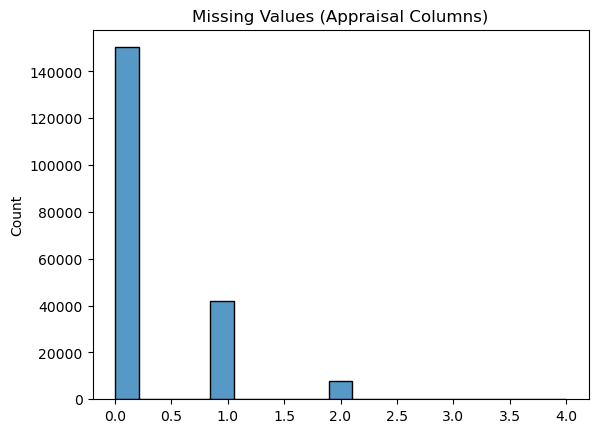

trim_descrip_appraisal     31080
model_appraisal            21508
online_appraisal_flag       3834
color_appraisal             1318
fuel_capacity_appraisal      312
mpg_city_appraisal             1
value_appraisal                0
model_year_appraisal           0
mileage_appraisal              0
make_appraisal                 0
body_appraisal                 0
engine_appraisal               0
cylinders_appraisal            0
mpg_highway_appraisal          0
horsepower_appraisal           0
market                         0
dtype: int64

In [7]:
report_missing_vals(kmax_data, subset="appraisal")

## Distribution of Vehicle Value
Since I'm particularly interested in predicting the value of vehicles, I'd like to pay particular attention to how value is distributed and varies.

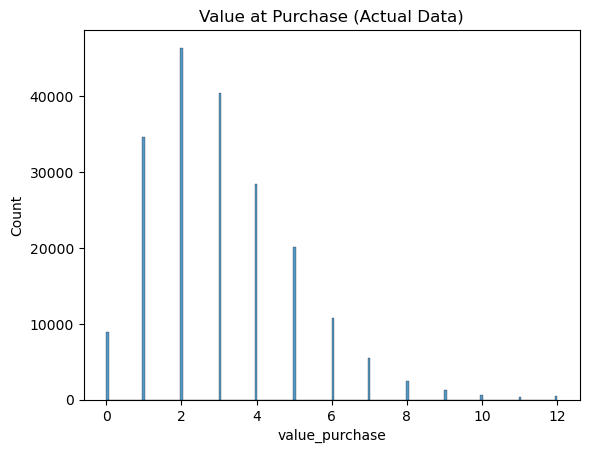

In [8]:
# Get price ranks
purch_val_rank_data = kmax_data['value_purchase'].rank(method="dense") - 1
# Plot price data
sns.histplot(x=purch_val_rank_data)
plt.title("Value at Purchase (Actual Data)");

### Is a Poisson a good fit for this data?

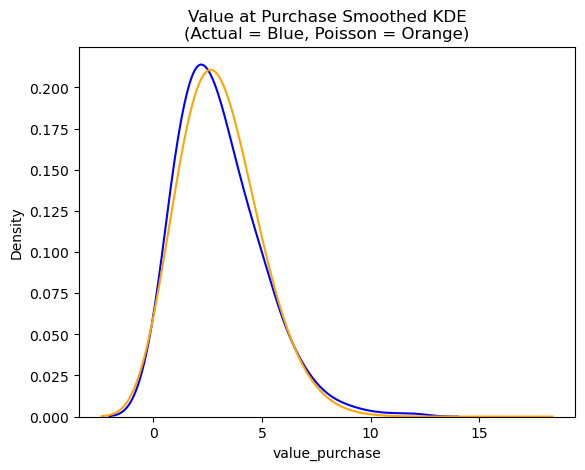

With a p-value of 1.0, we fail to reject the null hypothesis, thus the Poisson distribution is a good fit for the purchased value.


In [9]:
# Plot alongisde Poisson
rate_estimate = np.mean(purch_val_rank_data)  # Estimate the rate parameter as the mean of the data
sns.kdeplot(x=purch_val_rank_data, color="blue", bw_adjust=4)
sns.kdeplot(x=np.random.poisson(rate_estimate, len(purch_val_rank_data)*2), color="orange", bw_adjust=6)
plt.title("Value at Purchase Smoothed KDE\n(Actual = Blue, Poisson = Orange)")
plt.show()
plt.close()

# Perform goodness of fit testing using Chi-Square approximation
observed_counts = np.bincount(purch_val_rank_data).tolist()
num = sum(observed_counts)
expected_counts = [poisson.pmf(i, mu=rate_estimate)*num for i, _  in enumerate(observed_counts)]

# Add category for > the max found in actual data
observed_counts.append(0)
expected_counts.append((1- poisson.cdf(len(expected_counts), mu=3))*num)
expected_counts = np.array(expected_counts)
observed_counts = np.array(observed_counts)
# Calculate test statistic and p value
X2 = np.sum(np.square(observed_counts-expected_counts)/expected_counts)
df = num-len(observed_counts)-1-1
pval = chi2.sf(X2, df=df)

# Report result
result = ("is","fail to reject") if pval > .05 else ("is not", "reject")
print(f"With a p-value of {pval}, we {result[1]} the null hypothesis, thus the Poisson distribution {result[0]} a good fit for the purchased value.")

#### Purchase value is exceptionally well-modeled by a Poisson distribution.

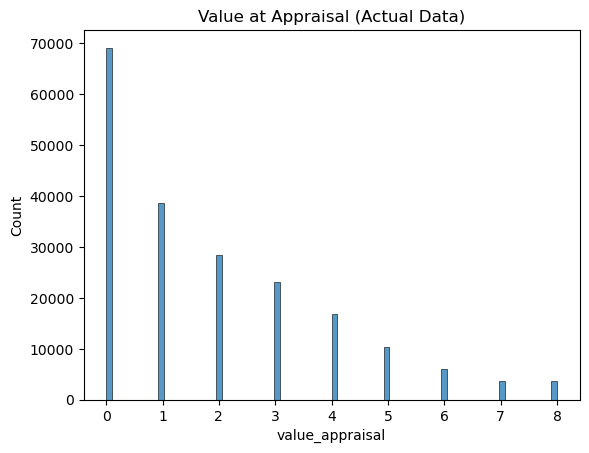

In [10]:
# Get price ranks
appr_val_rank_data = kmax_data['value_appraisal'].rank(method="dense") - 1
# Plot price data
sns.histplot(x=appr_val_rank_data)
plt.title("Value at Appraisal (Actual Data)");

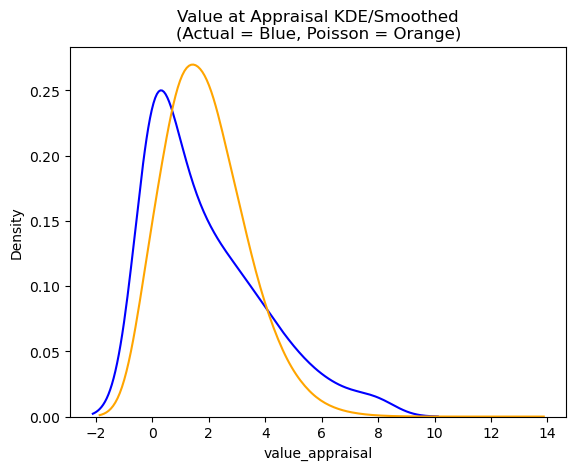

With a p-value of 2.2718756085303963e-85, we reject the null hypothesis, thus the Poisson distribution is not a good fit for the value at appraisal.


In [11]:
# Plot alongisde Poisson
rate_estimate = np.mean(appr_val_rank_data)  # Estimate the rate parameter as the mean of the data
sns.kdeplot(x=appr_val_rank_data, color="blue", bw_adjust=4)
sns.kdeplot(x=np.random.poisson(rate_estimate, len(appr_val_rank_data)*2), color="orange", bw_adjust=6)
plt.title("Value at Appraisal KDE/Smoothed\n(Actual = Blue, Poisson = Orange)")
plt.show()
plt.close()

# Perform goodness of fit testing using Chi-Square approximation
observed_counts = np.bincount(appr_val_rank_data).tolist()
num = sum(observed_counts)
expected_counts = [poisson.pmf(i, mu=rate_estimate)*num for i, _  in enumerate(observed_counts)]

# Add category for > the max found in actual data
observed_counts.append(0)
expected_counts.append((1- poisson.cdf(len(expected_counts), mu=3))*num)
expected_counts = np.array(expected_counts)
observed_counts = np.array(observed_counts)
# Calculate test statistic and p value
X2 = np.sum(np.square(observed_counts-expected_counts)/expected_counts)
df = num-len(observed_counts)-1-1
pval = chi2.sf(X2, df=df)

# Report result
result = ("is","fail to reject") if pval > .05 else ("is not", "reject")
print(f"With a p-value of {pval}, we {result[1]} the null hypothesis, thus the Poisson distribution {result[0]} a good fit for the value at appraisal.")

#### Unlike value at purchase, appraisal value is not well-modeled by a Poisson distribution.

# Ordinal Correlations

I look in-depth at ordinal correlations in some R Markdown notebooks using a combination of mosaic plots (like the ones below, but using ggmosaic) and Kendall's Tau (a non-parametric correlation coefficient suited to ordinal x ordinal data).

In my R notebooks I use bootstrapping to generate confidence intervals for Kendall's tau within different groups to show that at least some makes, colors, bodies, etc. have different correlations between appraisal offer and purchase price, suggesting that they might provide additional information we can use to predict the price of the customer's purchase vehicle.

**Since I've already done some EDA with this in R**, I will be brief here. I will only attempt to give a vague idea of some of the methods that can be used and the observations to be made.

In [12]:
def generate_mosaic_plot(data: pd.DataFrame, x: str, y: str, scale: Tuple[float, float]  = (1,1)):
    """
    Generates a mosaic plot from two ordinal variables using statsmodels.graphics.mosaicplot.

    Args:
        data (pandas.DataFrame): The input data containing the variables.
        x (str): The name of the variable for the x-axis.
        y (str): The name of the variable for the y-axis.
    """
    _data = data[~data[x].isna() & ~data[y].isna()]
    # Prepare the data for the mosaic plot
    cross_table = pd.crosstab(_data[x], _data[y])
    plot_data = cross_table.stack()

    # Calculate stats as needed
    if  is_numeric_dtype(data[x]):
        dtype_x = True
    else:
        try:
            dtype_x = data[x].cat.ordered
        except:
            dtype_x = False

    if  is_numeric_dtype(data[y]):
        dtype_y = True
    else:
        try:
            dtype_y = data[y].cat.ordered
        except:
            dtype_y = False

    if dtype_x and dtype_y:
        # Ignore warnings for now / this is more for exploration, some overflows are fine
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        tau = kendalltau(_data[x].rank(method='dense'), _data[y].rank(method='dense'))[0]
        warnings.filterwarnings("default", category=RuntimeWarning)
    else:
        tau = False

    # Create the mosaic plot
    nx = scale[0]
    ny = scale[1]
    N_x = len(_data[x].unique())
    N_y = len(_data[y].unique())
    _, ax = plt.subplots(figsize=(N_x/3*nx, N_y/3*ny))
    stat = "" if not tau else f" (τ = {tau:.2})"
    mosaic(plot_data, ax=ax, title=f"{x} by {y}{stat}", labelizer=lambda _: "", label_rotation=(-90,0), statistic=True, gap=.075)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    # Plot and close
    plt.show()
    plt.close()
    

## Price and Mileage

Here we can see that appraisal/purchasee price are moderately well-correlated (positive correlation), while appraisal/purchase mileage are positively correlated (τ indicates Kendall's Tau).

Regions of red indicate regions that are >2 SD more common than expected under no association; blue is >2 SD less common than expected. Green indicaated within 2 SD of expected value.

Further, you can see that highly appraised vehicles are extremely rare (this is probably only made worse by the un-even price brackets used)

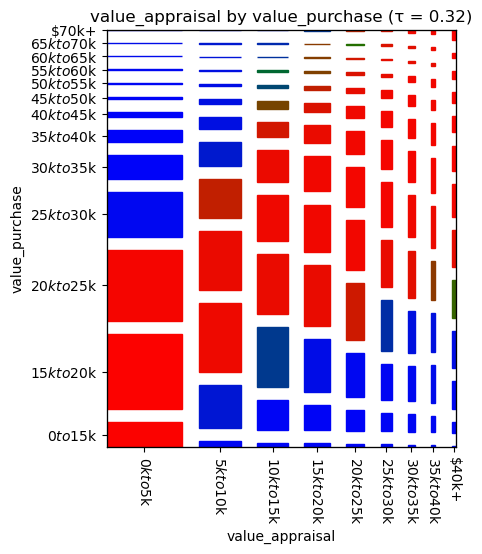

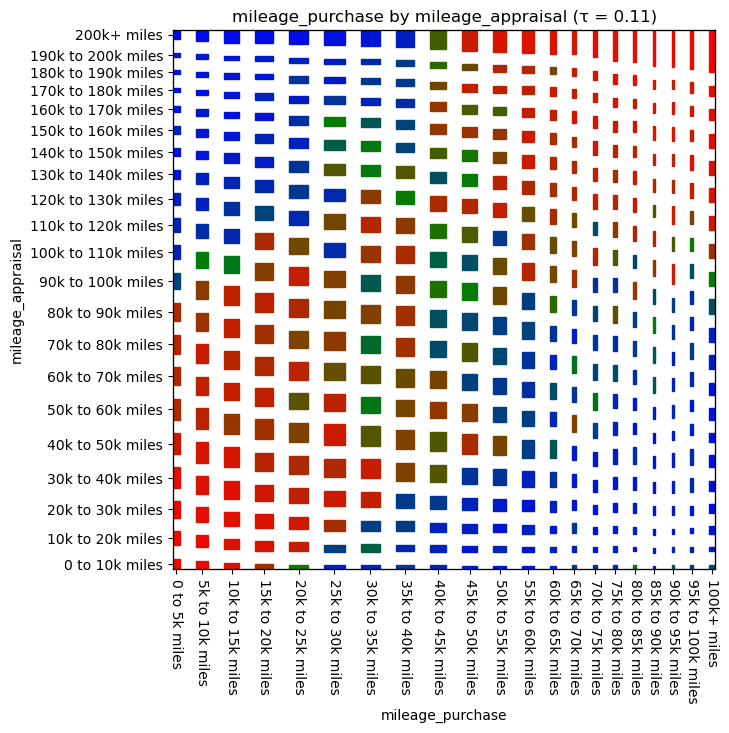

In [13]:
generate_mosaic_plot(kmax_data, "value_appraisal", "value_purchase", scale = (1.5, 1.25))
generate_mosaic_plot(kmax_data, "mileage_purchase", "mileage_appraisal")

### Value and Mileage
Here we can see that price (appraisal or purchase) is negatively associated with mileage (appraisal or purchase). This is even true comparing purchase price vs appraisal mileage and vice versa.

Regions of red indicate regions that are >2 SD more common than expected under no association; blue is >2 SD less common than expected. Green indicaated within 2 SD of expected value.

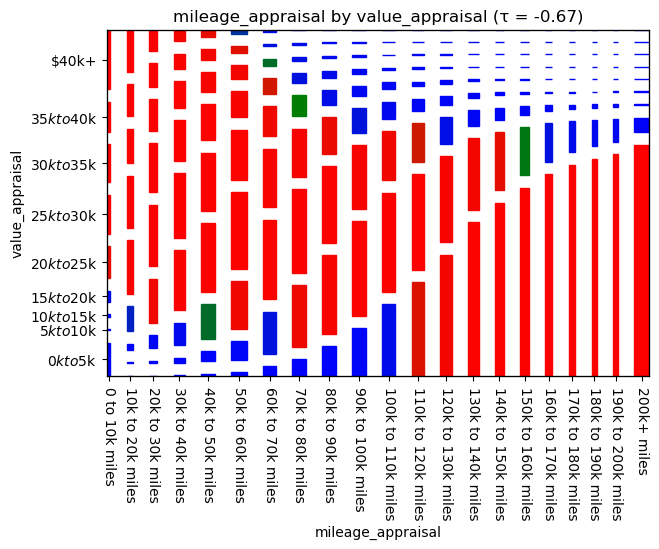

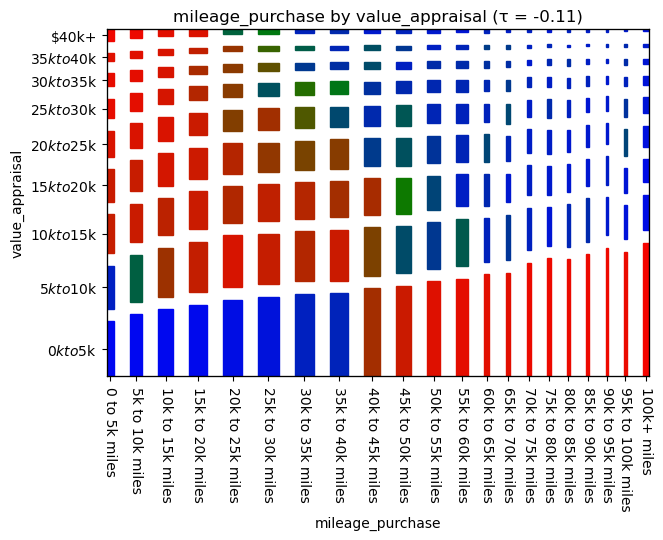

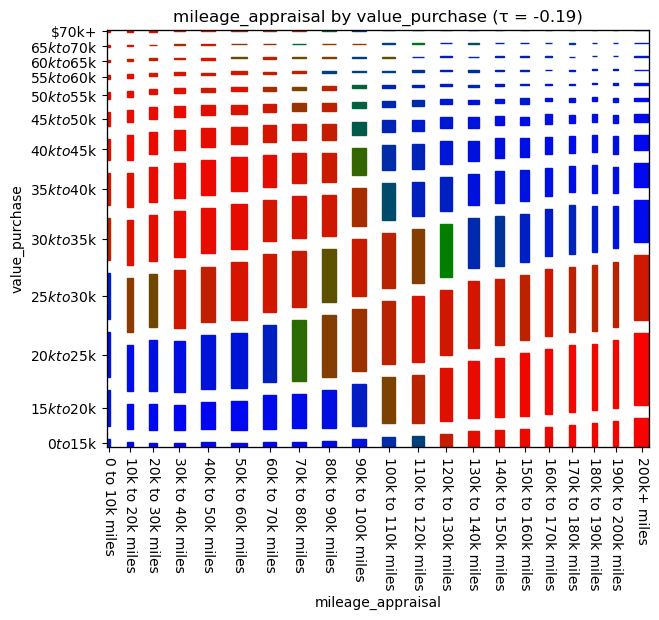

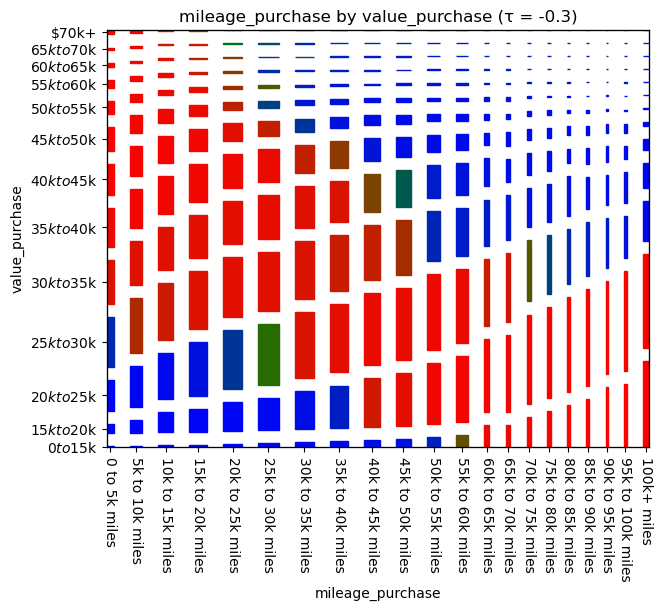

In [14]:
generate_mosaic_plot(kmax_data,  "mileage_appraisal", "value_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "mileage_purchase", "value_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "mileage_appraisal","value_purchase", scale=(1,1.25))
generate_mosaic_plot(kmax_data, "mileage_purchase", "value_purchase", scale=(1,1.25))

## Make and Model
One of my primary questions here is the dimensionality of make/model.

How are the frequencies of different makes/models distributed. Are some exceptionally rare? Are the sets of makes/models similar between appraisals and purchase vehicles?

To make some of the data exploration for this (and other visualizations) easier, I will convert to a long format that is more agnostic towards appraisals/purchases.

In [15]:
long_kmax_data = carmax_short_to_long(kmax_data)
long_kmax_data.to_pickle(DATA/"long_kmax.pkl")
long_kmax_data

market  online_appraisal_flag         value  model_year  \
0           13                    1.0  $20k to $25k        2014   
1           11                    0.0  $15k to $20k        2006   
2           13                    1.0  $30k to $35k        2014   
3           13                    1.0  $35k to $40k        2014   
4           16                    1.0  $30k to $35k        2011   
...        ...                    ...           ...         ...   
399995       1                    1.0  $15k to $20k        2015   
399996       8                    0.0  $10k to $15k        2010   
399997       3                    0.0    $0k to $5k        2004   
399998      11                    0.0  $10k to $15k        2006   
399999      14                    0.0  $15k to $20k        2009   

                   mileage make   model trim_descrip body   color  engine  \
0         15k to 20k miles  HDT  HDT_12      Premium    E     Red     2.0   
1              100k+ miles  KQZ  KQZ_23      Premium    E  Silver     3.5   
2          5k to 10k miles  CZV  CZV_10      Premium    E   Black     2.5   
3         15k to 20k miles  IZA  IZA_19      Premium    F  Silver     2.0   
4         35k to 40k miles  HDT   HDT_8      Premium    F    Blue     2.5   
...                    ...  ...     ...          ...  ...     ...     ...   
399995      0 to 10k miles  LTX  LTX_30  Not Premium    E   Black     1.4   
399996    50k to 60k miles  HXQ   HXQ_8  Not Premium    B   Black     1.8   
399997  120k to 130k miles  HXQ  HXQ_14  Not Premium    F    Gray     2.4   
399998  130k to 140k miles  BZQ   BZQ_4      Premium    D   White     5.7   
399999    70k to 80k miles  FJE   FJE_9      Premium    E    Blue     5.7   

        cylinders  mpg_city  mpg_highway  horsepower  fuel_capacity  \
0               4      27.0         33.0         152           16.0   
1               6      19.0         27.0         285           18.0   
2               4      24.0         30.0         187           15.0   
3               4      25.0         34.0         255           15.0   
4               4      17.0         23.0         305           15.0   
...           ...       ...          ...         ...            ...   
399995          4      26.0         31.0         138           14.0   
399996          4      30.0         39.0         143           13.0   
399997          4      21.0         30.0         177           18.0   
399998          8      13.0         19.0         390           26.0   
399999          8      18.0         25.0         360           24.0   

       itransaction  
0          purchase  
1          purchase  
2          purchase  
3          purchase  
4          purchase  
...             ...  
399995    appraisal  
399996    appraisal  
399997    appraisal  
399998    appraisal  
399999    appraisal  

[400000 rows x 17 columns]

#### Are appraised models all unique to a specific make?

In [16]:
appr_make_model = kmax_data['model_appraisal'] + kmax_data['make_appraisal']
len(kmax_data['model_appraisal'].unique()) == len(appr_make_model.unique())

True

#### How many models are shared in appraised vs purchase data

In [17]:
appr_models = set(kmax_data['model_appraisal'])
purch_models = set(kmax_data['model_purchase'])
print(f"{len(appr_models.intersection(purch_models))} shared models.")
print(f"{len(appr_models.union(purch_models))} total models.")

409 shared models.
842 total models.


In [18]:
# Get most common model for each make
app_most_common_models = long_kmax_data.groupby('make')['model'].agg(pd.Series.mode)
imputed_app_models_by_make = app_most_common_models.to_dict()
### Fill based on most common appraisal model for each make
kmax_data['model_appraisal_imputed'] = kmax_data['model_appraisal'].isna()
kmax_data['model_appraisal'] = kmax_data['model_appraisal'].fillna(kmax_data['make_appraisal'].map(imputed_app_models_by_make))

## Vehicle Body

In [19]:
# Get mumber of bodies per model
app_model_bodies = kmax_data.groupby('model_appraisal')['body_appraisal'].nunique()
pur_model_bodies = kmax_data.groupby('model_purchase')['body_purchase'].nunique()
model_bodies = long_kmax_data.groupby('model')['body'].nunique()

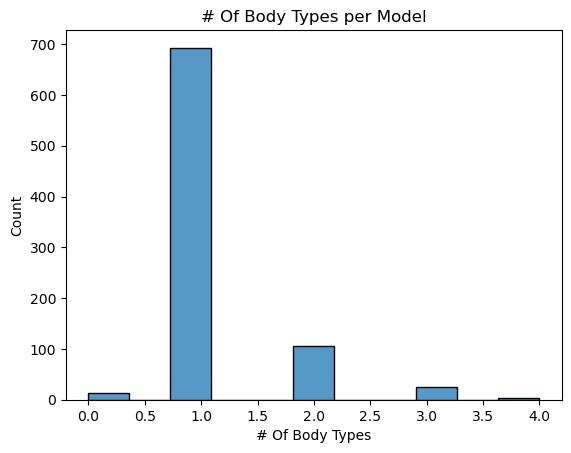

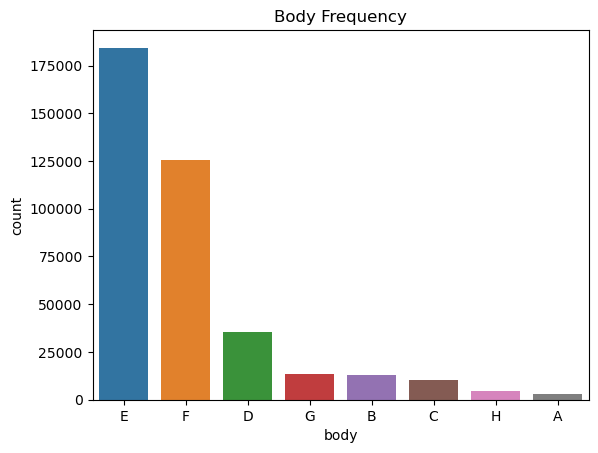

In [20]:
# Uniquness by model
sns.histplot(model_bodies)
plt.xlabel("# Of Body Types")
plt.title("# Of Body Types per Model")
plt.show()
plt.close()

# Frequency
body_freqs = long_kmax_data["body"].value_counts(sort=True).reset_index().rename(columns={"index":"body","body":"count"})
sns.barplot(y="count", x="body", data=body_freqs)
plt.title("Body Frequency")
plt.show()
plt.close()

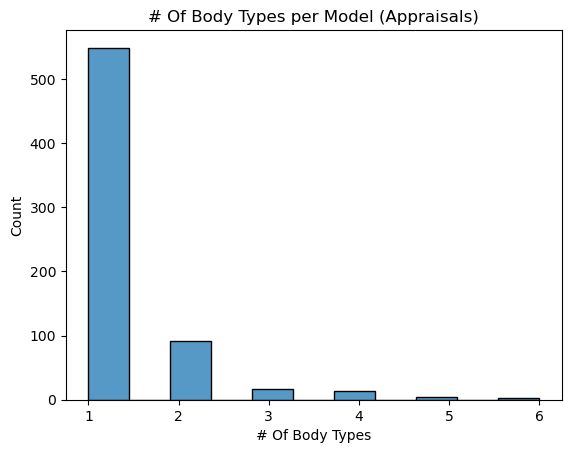

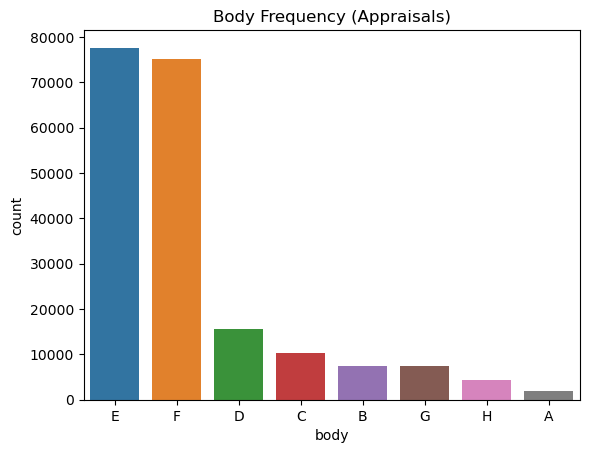

In [21]:
# Uniquness by model
sns.histplot(app_model_bodies)
plt.xlabel("# Of Body Types")
plt.title("# Of Body Types per Model (Appraisals)")
plt.show()
plt.close()

# Frequency
body_freqs = kmax_data["body_appraisal"].value_counts(sort=True).reset_index().rename(columns={"index":"body","body_appraisal":"count"})
sns.barplot(y="count", x="body", data=body_freqs)
plt.title("Body Frequency (Appraisals)")
plt.show()
plt.close()

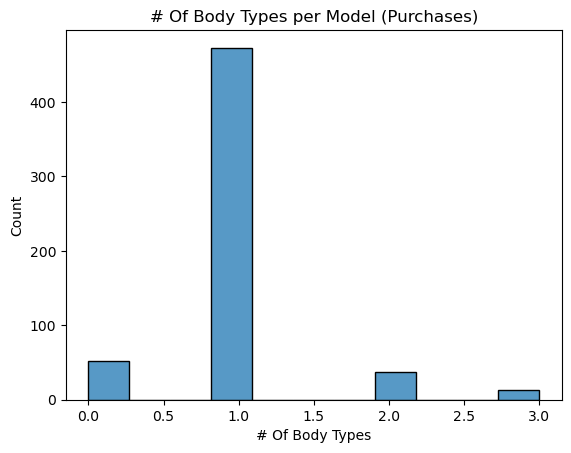

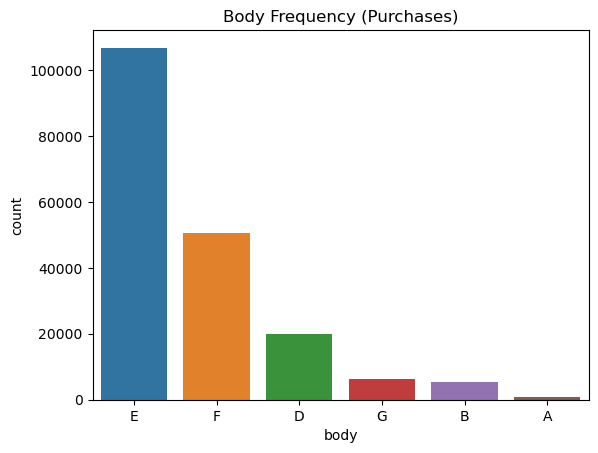

In [22]:
# Uniquness by model
sns.histplot(pur_model_bodies)
plt.xlabel("# Of Body Types")
plt.title("# Of Body Types per Model (Purchases)")
plt.show()
plt.close()

# Frequency
body_freqs = kmax_data["body_purchase"].value_counts(sort=True).reset_index().rename(columns={"index":"body","body_purchase":"count"})
sns.barplot(y="count", x="body", data=body_freqs)
plt.title("Body Frequency (Purchases)")
plt.show()
plt.close()

#### Insights on body
The order of vehicle popularity is generally the same for appraisals and purchases, though the exact bodies differ slightly with some only being seen among appraisals.

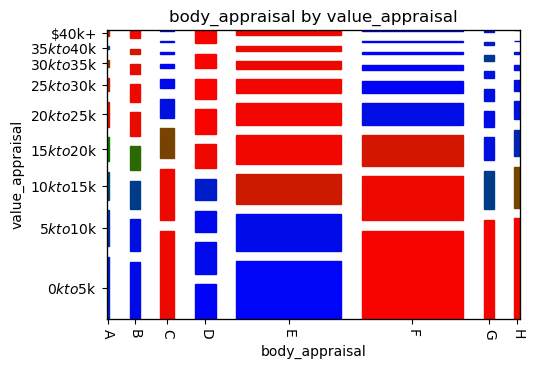

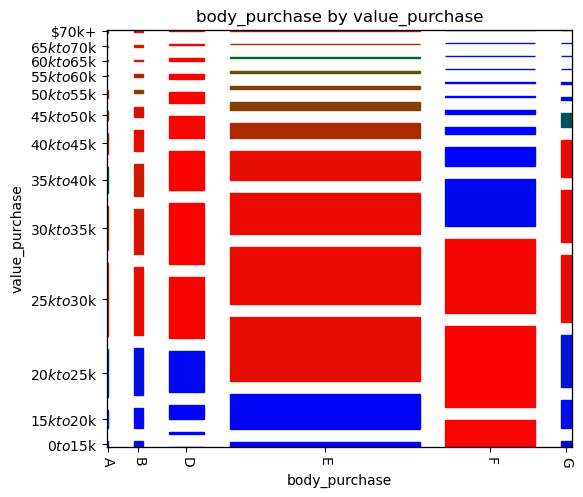

In [23]:
generate_mosaic_plot(kmax_data, "body_appraisal", "value_appraisal", scale = (2,1.25))
generate_mosaic_plot(kmax_data, "body_purchase", "value_purchase", scale =(3,1.25))

* A, B, D are all lower in value (in both datasets)
* F is higher in value (in both datasets)
* G behaves differently in both datasets (mid-ranged in purchases, higher in appraisals)
* C and H are unique to appraisals and are both low valued.

## Non-ordinal Numeric Categories
Next I'll look at regular numeric categories.

Plus cylinders--which is actually decidedly ordinal (more on this later)--and model year which is confined to integers but behaves very much like a continuous variable.

### Model Year
In particular, I'm curious how much model year feeds into value. I would expect newer cars to be worth much more. This probably also corresponds well with the mileage on the vehicle, so I'll plot both of those.

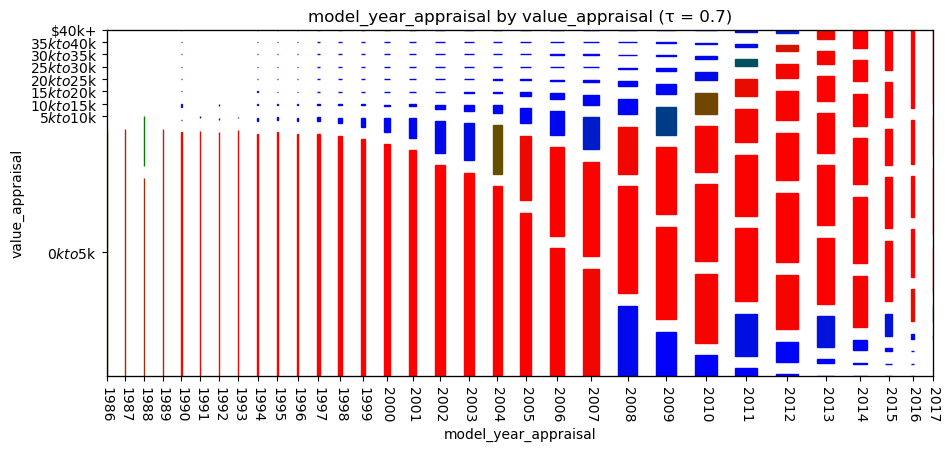

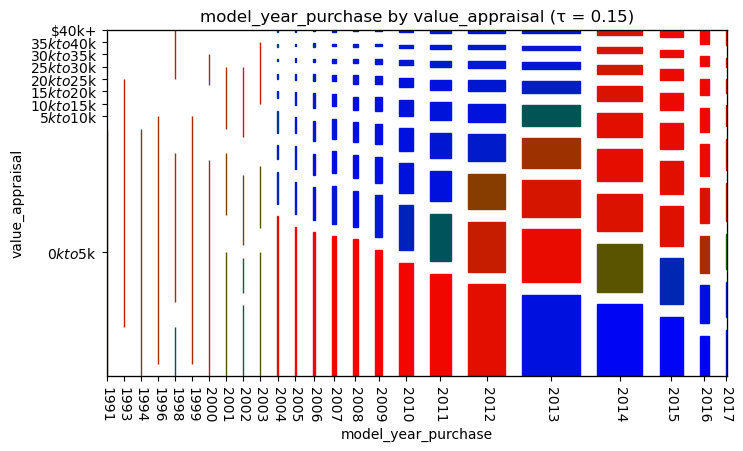

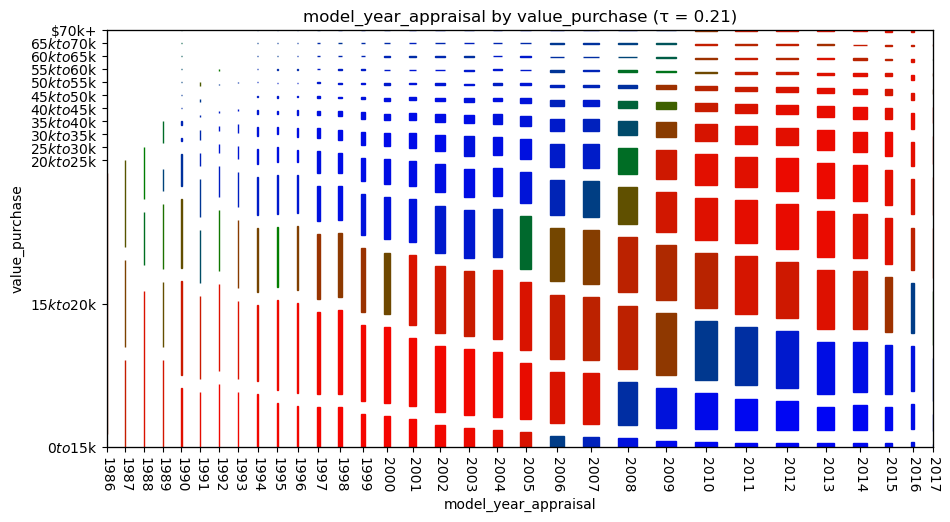

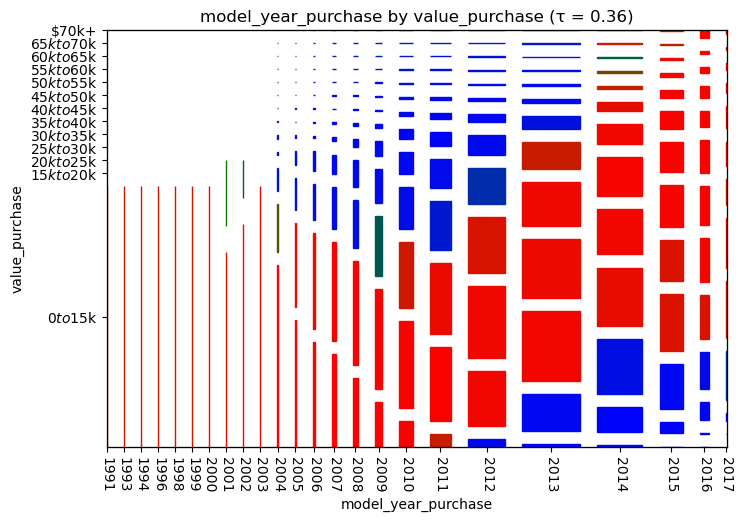

In [24]:
generate_mosaic_plot(kmax_data,  "model_year_appraisal", "value_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "model_year_purchase", "value_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "model_year_appraisal","value_purchase", scale=(1,1.25))
generate_mosaic_plot(kmax_data, "model_year_purchase", "value_purchase", scale=(1,1.25))

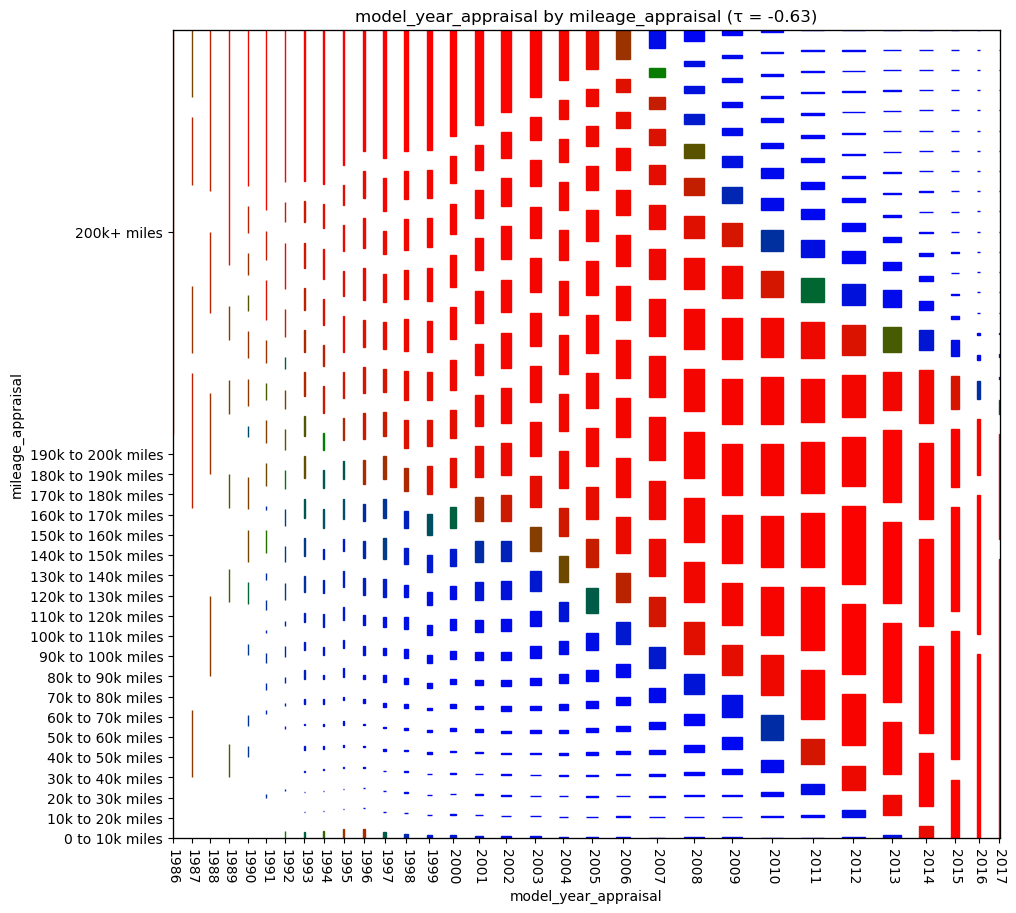

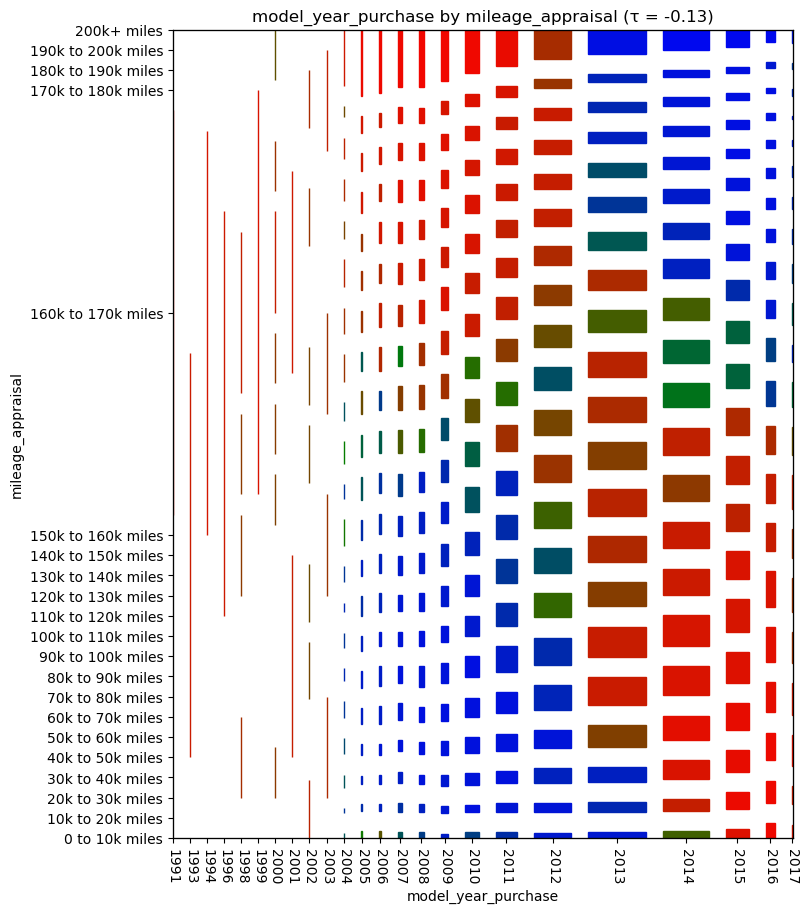

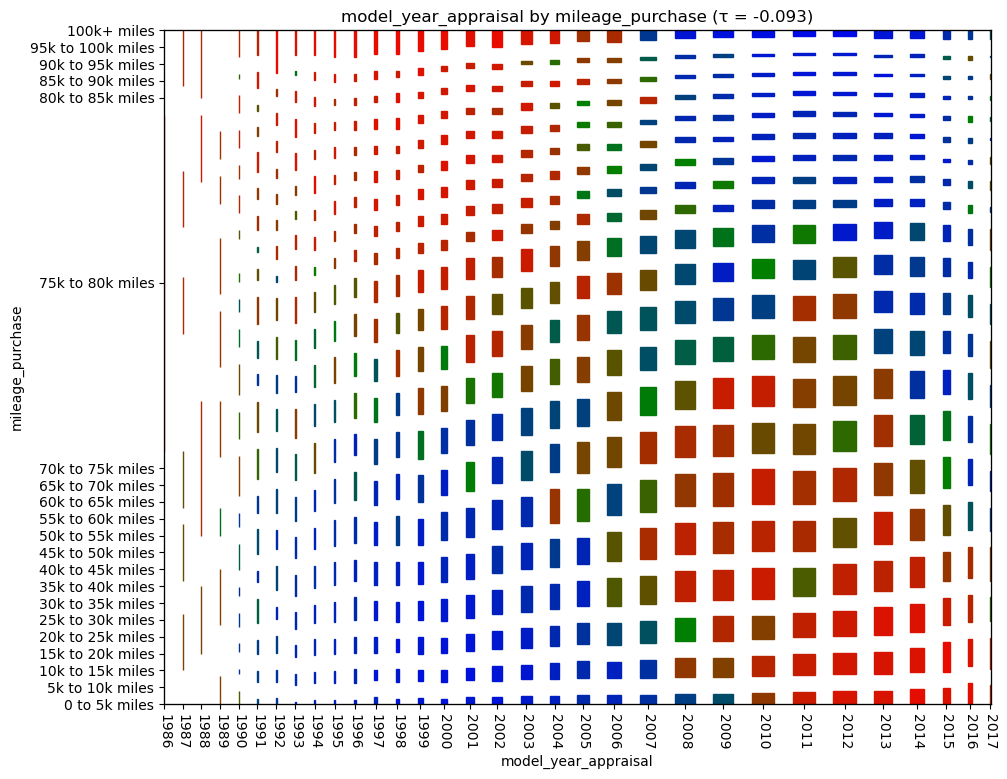

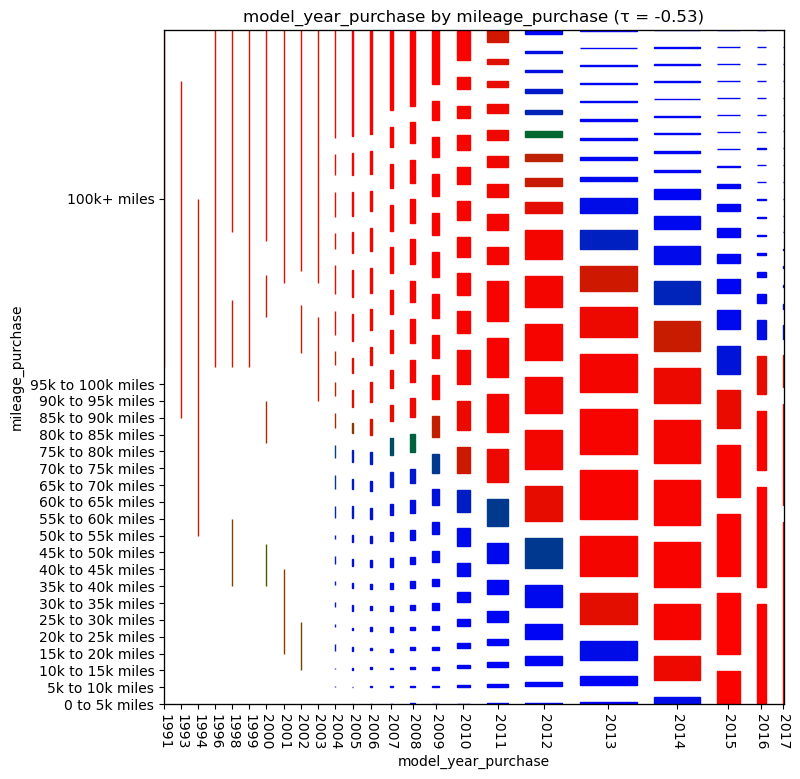

In [25]:
generate_mosaic_plot(kmax_data,  "model_year_appraisal", "mileage_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "model_year_purchase", "mileage_appraisal", scale=(1,1.5))
generate_mosaic_plot(kmax_data, "model_year_appraisal","mileage_purchase", scale=(1,1.25))
generate_mosaic_plot(kmax_data, "model_year_purchase", "mileage_purchase", scale=(1,1.25))

### Engine and Vehicle Performance
Many of the remaining factors relate to another in some way (engine volume & horsepower, mpg highway/mpg city, etc.) to one another.

They also *should* vary based on body type (i.e. trucks tend to have nore horsepower than a small sedan).

Therefore, I'll visualize these relationships against one another. Alongside body, I'm curious if any of them vary by year.

In [26]:
numeric_cols = {"engine":"Engine Volume", "cylinders": "# Cylinders", "mpg_city": "MPG City", "mpg_highway": "MPG Hwy", "horsepower": "Horsepower", "fuel_capacity": "Fuel Capacity", "model_year": "Model Year"}

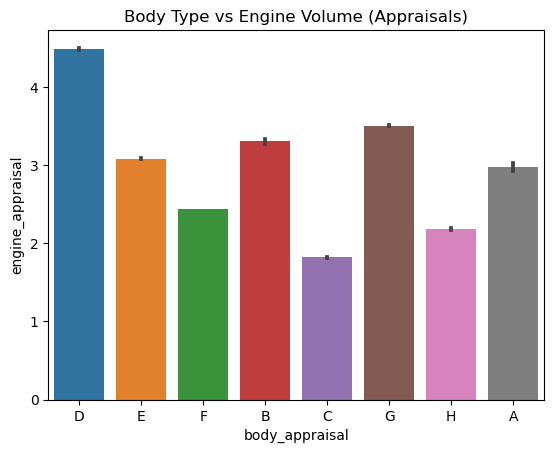

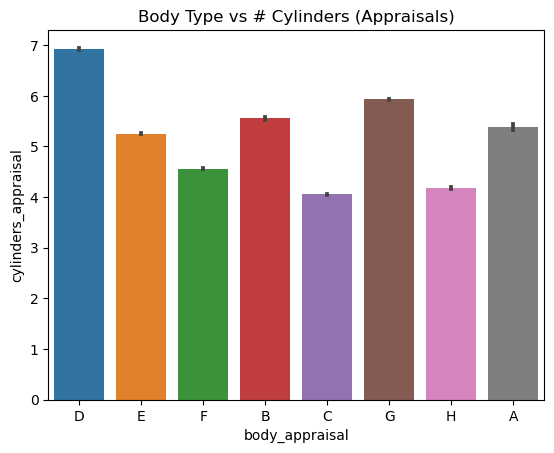

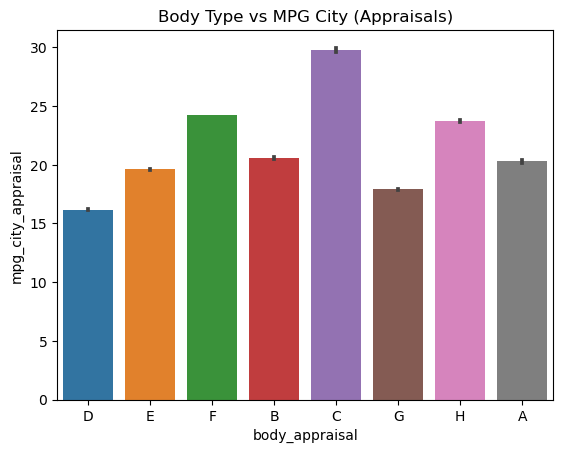

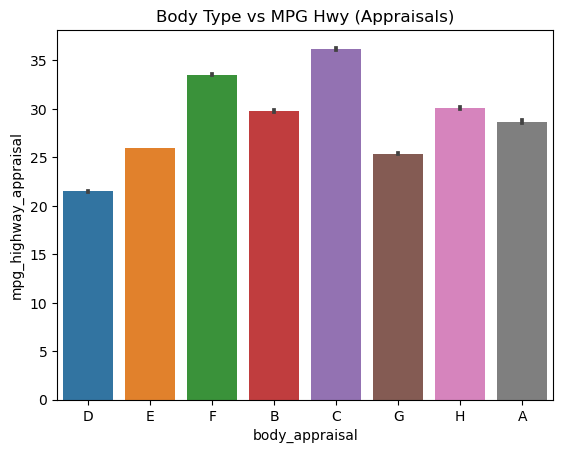

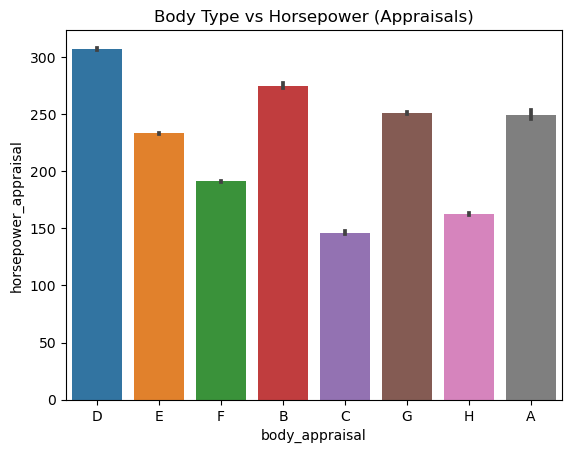

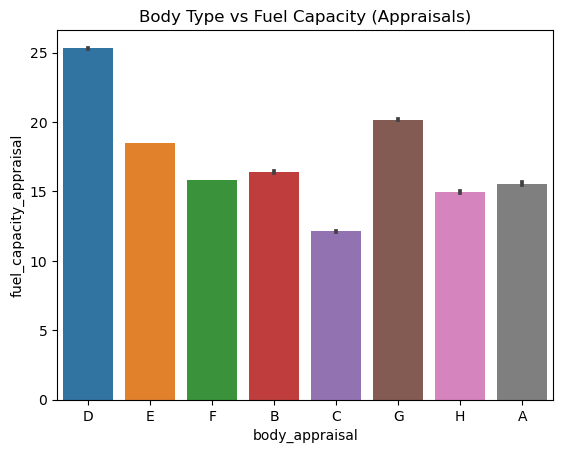

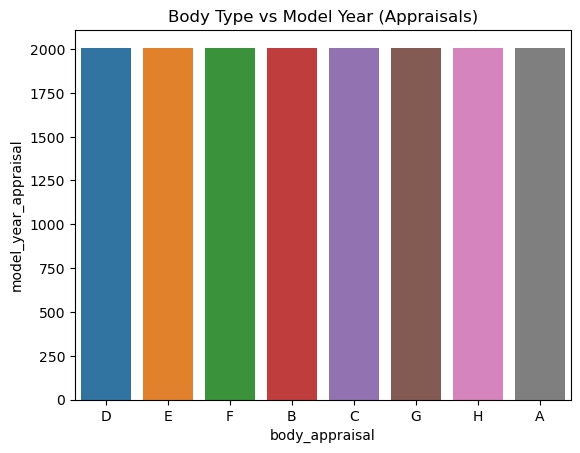

In [27]:
for y,lbl in numeric_cols.items():
    sns.barplot(data=kmax_data, x="body_appraisal", y=f"{y}_appraisal")
    plt.title(f"Body Type vs {lbl} (Appraisals)")
    plt.show()
    plt.close()

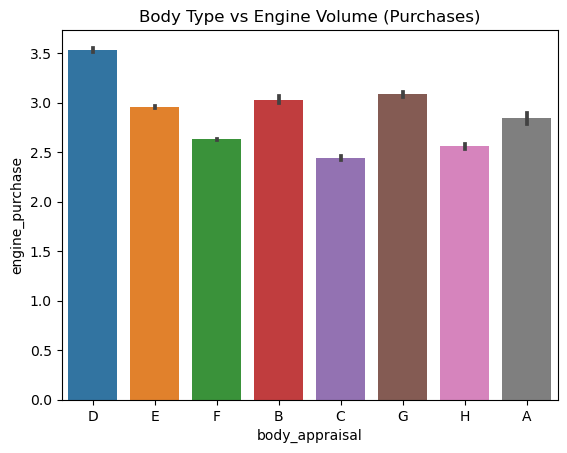

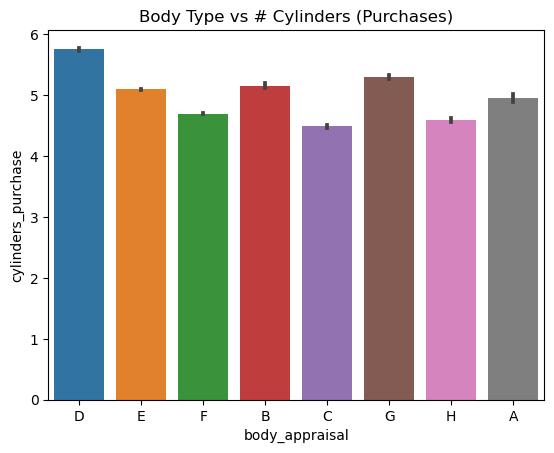

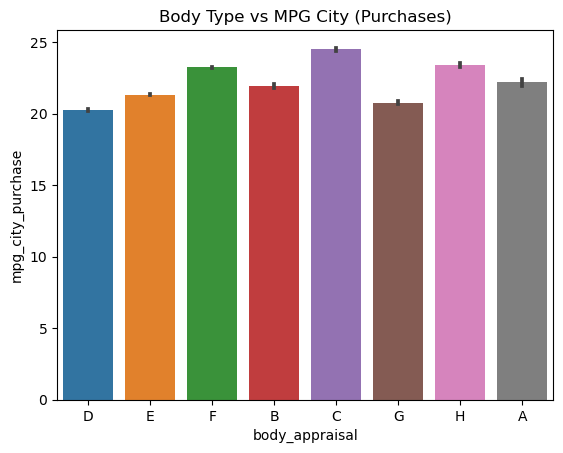

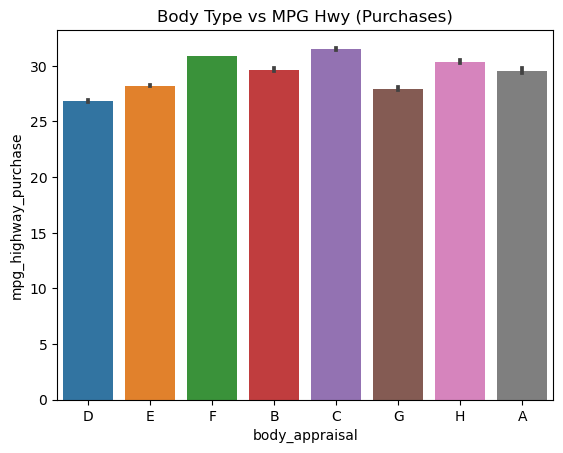

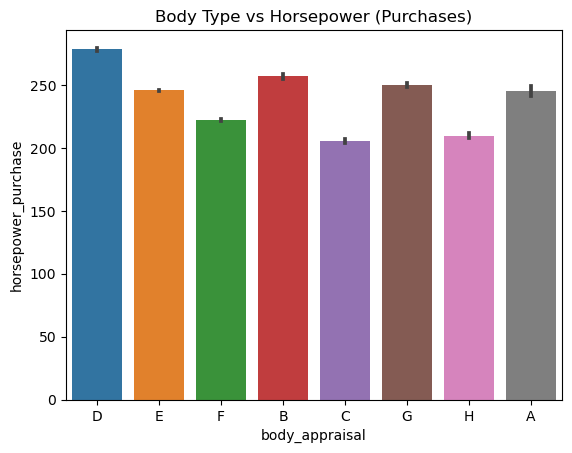

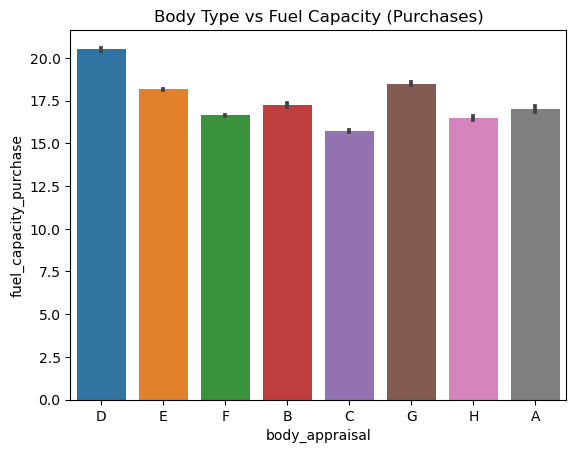

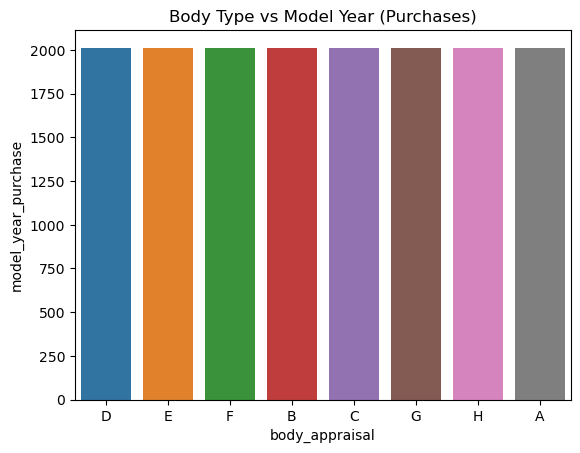

In [28]:
for y,lbl in numeric_cols.items():
    sns.barplot(data=kmax_data, x="body_appraisal", y=f"{y}_purchase")
    plt.title(f"Body Type vs {lbl} (Purchases)")
    plt.show()
    plt.close()

Strangely, several of the differences specific to bodies are less pronounced in purchase vehicles, though strong differences are still apparent when considering both the appraised and purchase vehicles together (below).

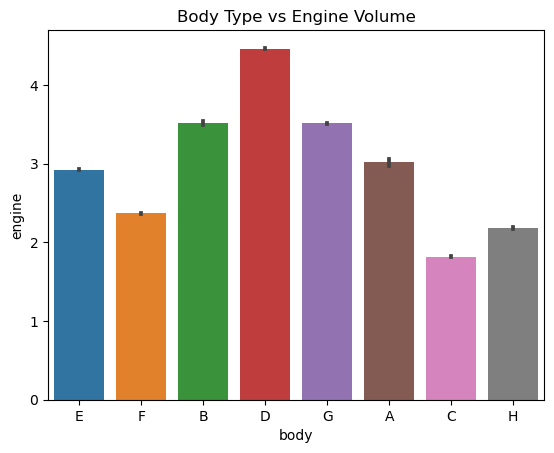

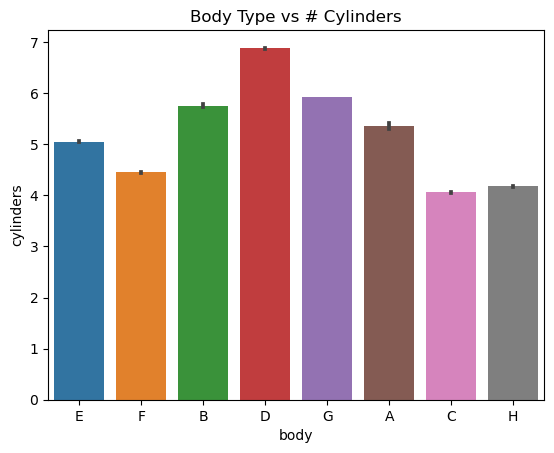

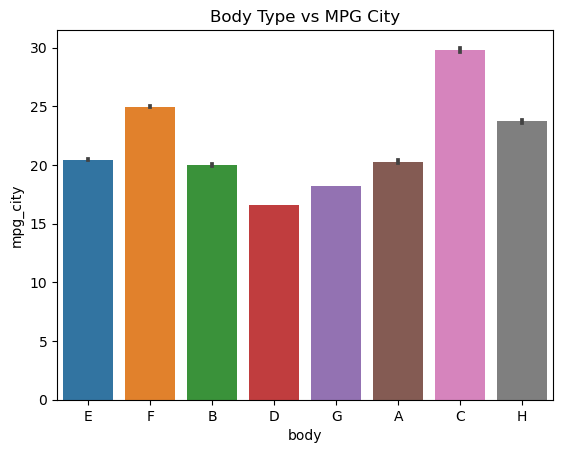

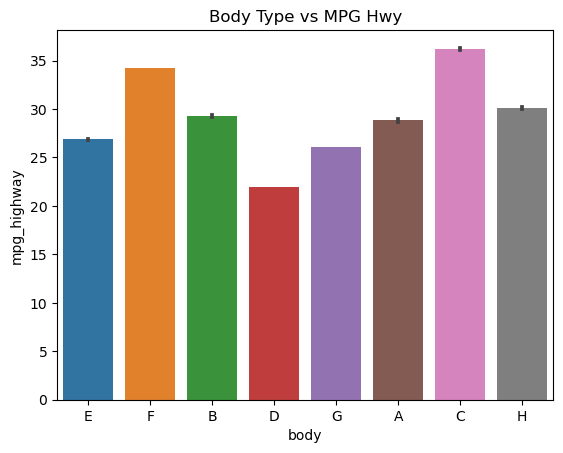

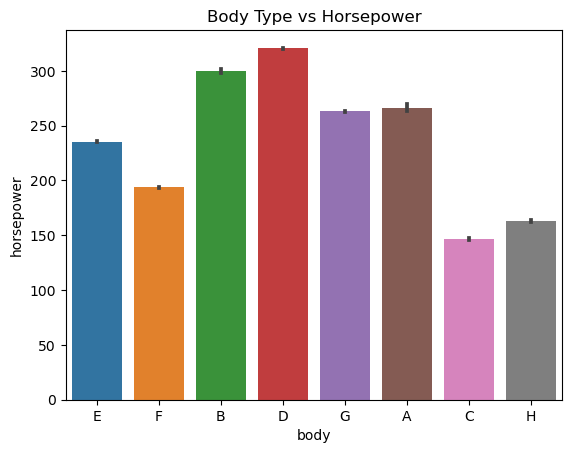

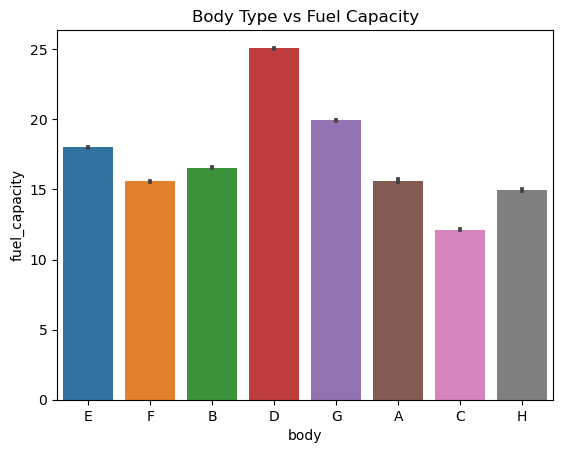

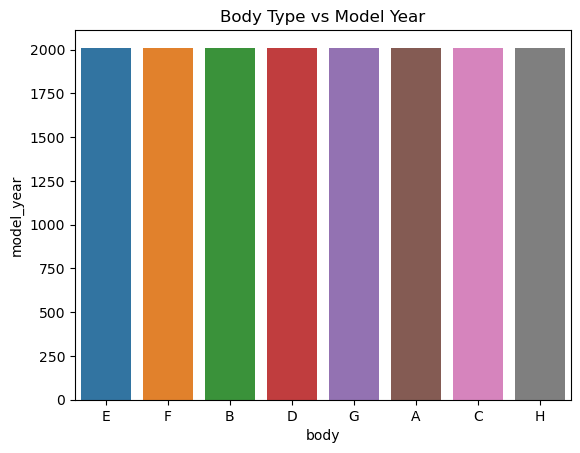

In [29]:
for y,lbl in numeric_cols.items():
    sns.barplot(data=long_kmax_data, x="body", y=y)
    plt.title(f"Body Type vs {lbl}")
    plt.show()
    plt.close()

Note that the differences in body type for engine volume, # of cylinders, horsepower, and fuel capacity all generally track with each other. The same is true for mpg city/highway across different body types.

These trends are likely to hold when we look at them one-one-one, which we'll do next. 

c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


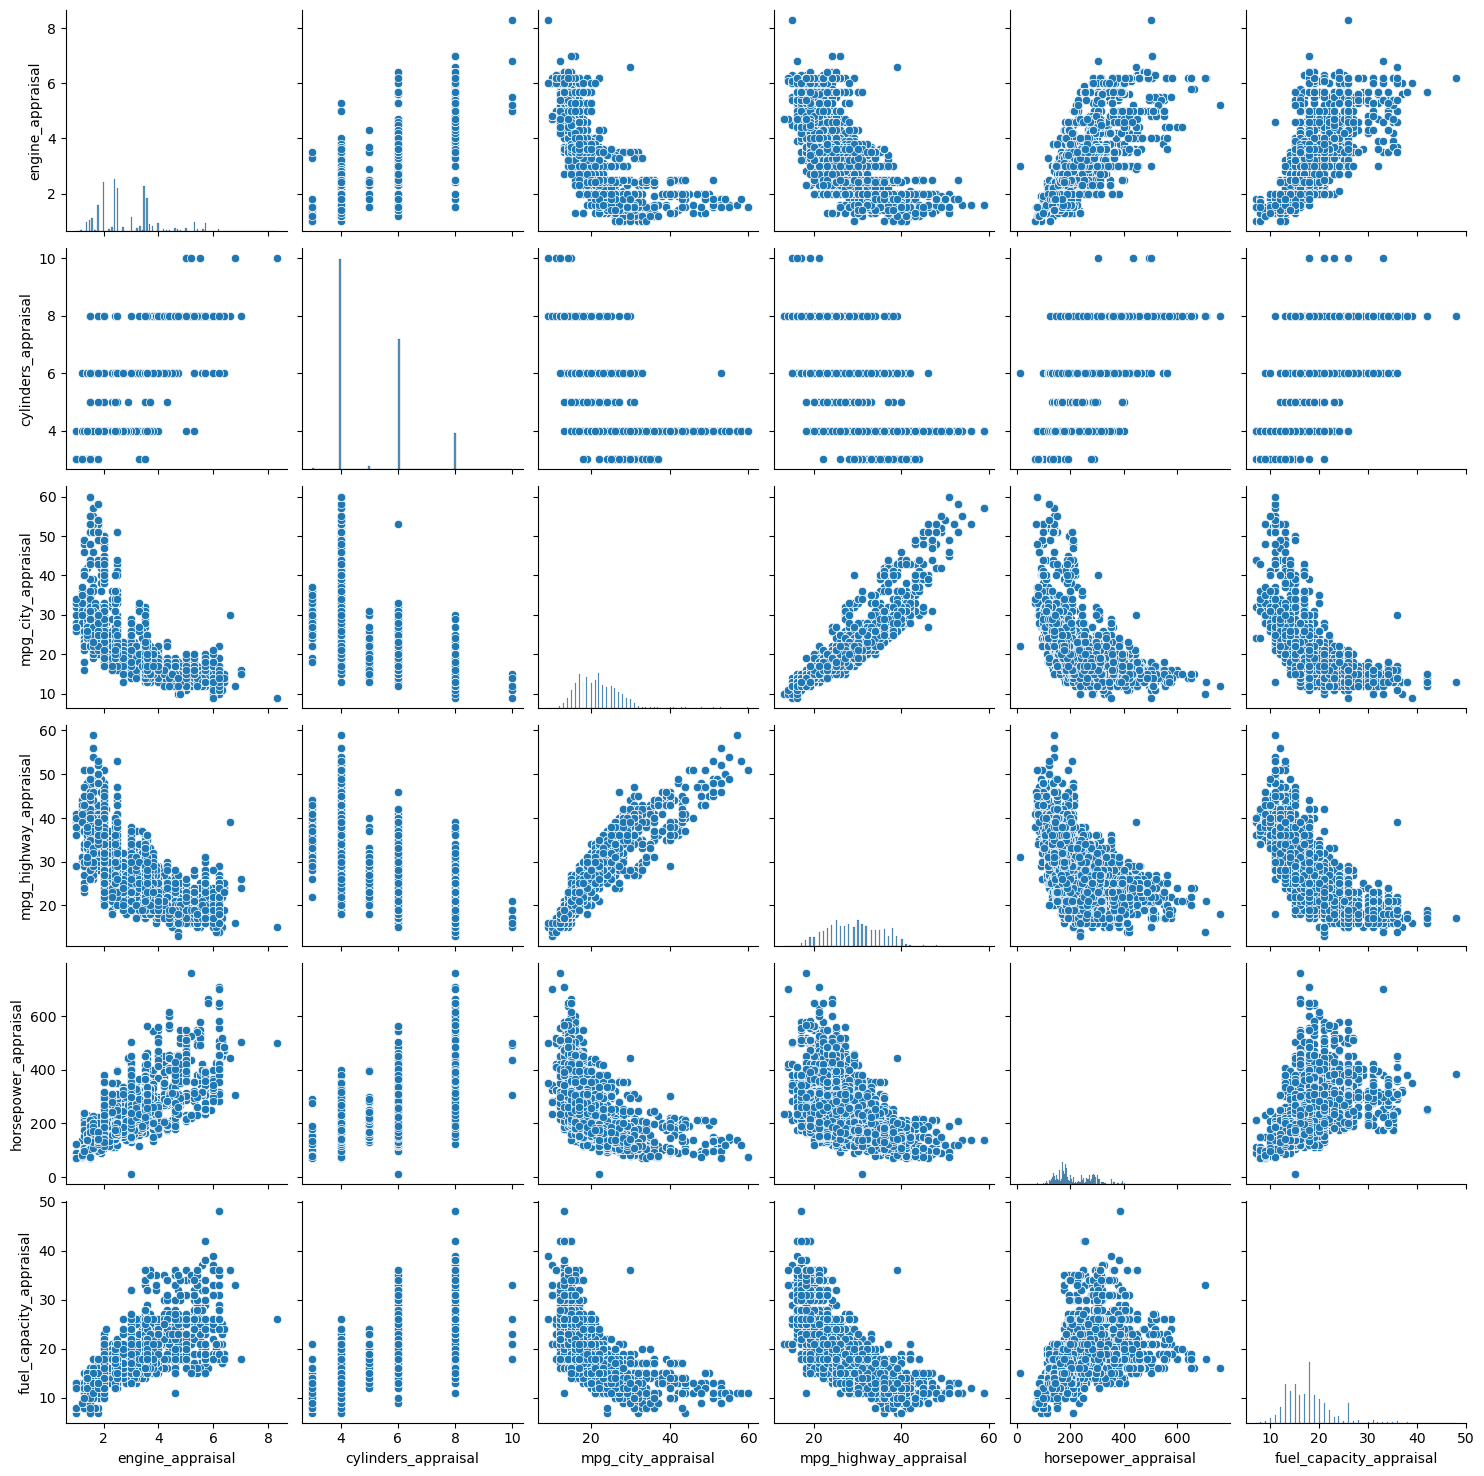

In [30]:
appr_pair_cols = [f"{c}_appraisal" for c in numeric_cols.keys() if c != "model_year"]
sns.pairplot(data=kmax_data[appr_pair_cols]);

c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


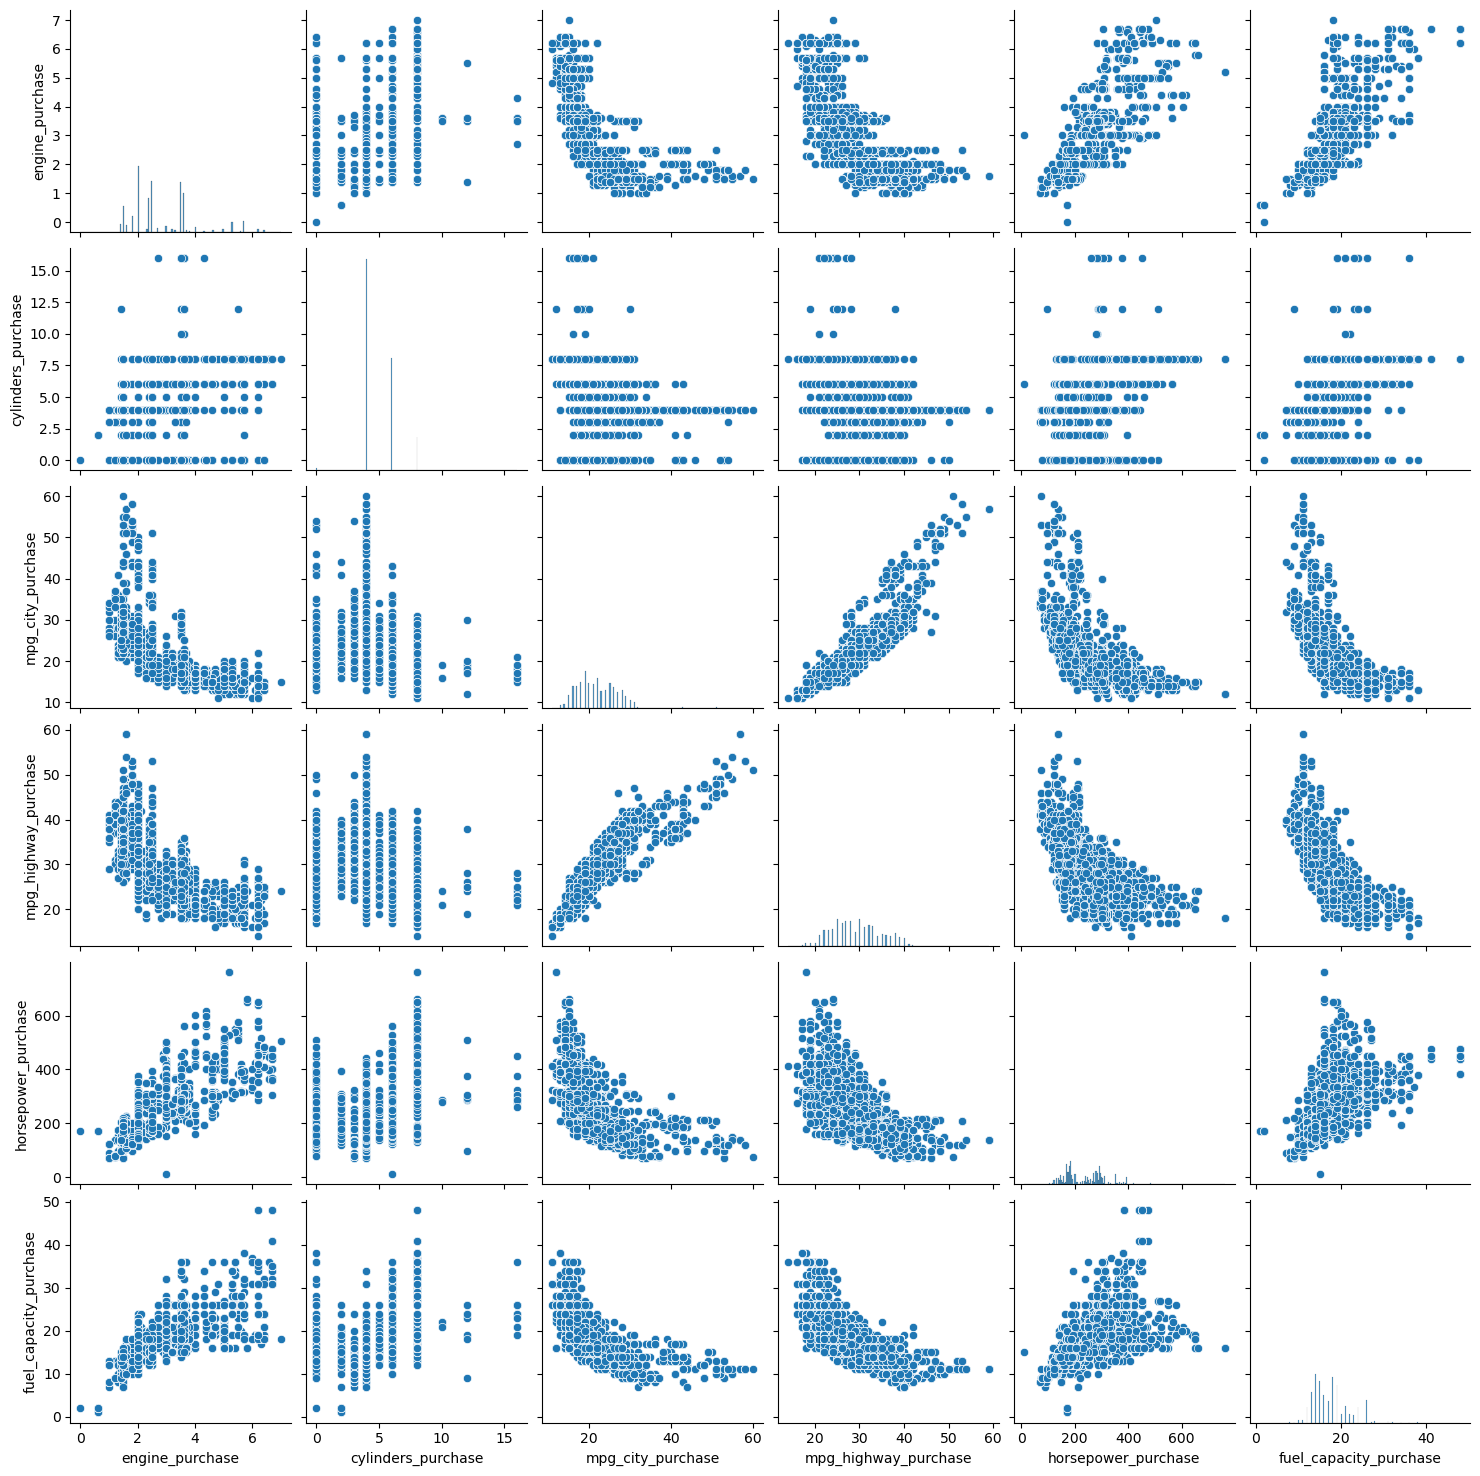

In [31]:
pur_pair_cols = [f"{c}_purchase" for c in numeric_cols.keys() if c != "model_year"]
sns.pairplot(data=kmax_data[pur_pair_cols]);

Notice that both appraisals and purchass have similar relationships for all of these variables.

c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\nkueh\anaconda3\envs\py310\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


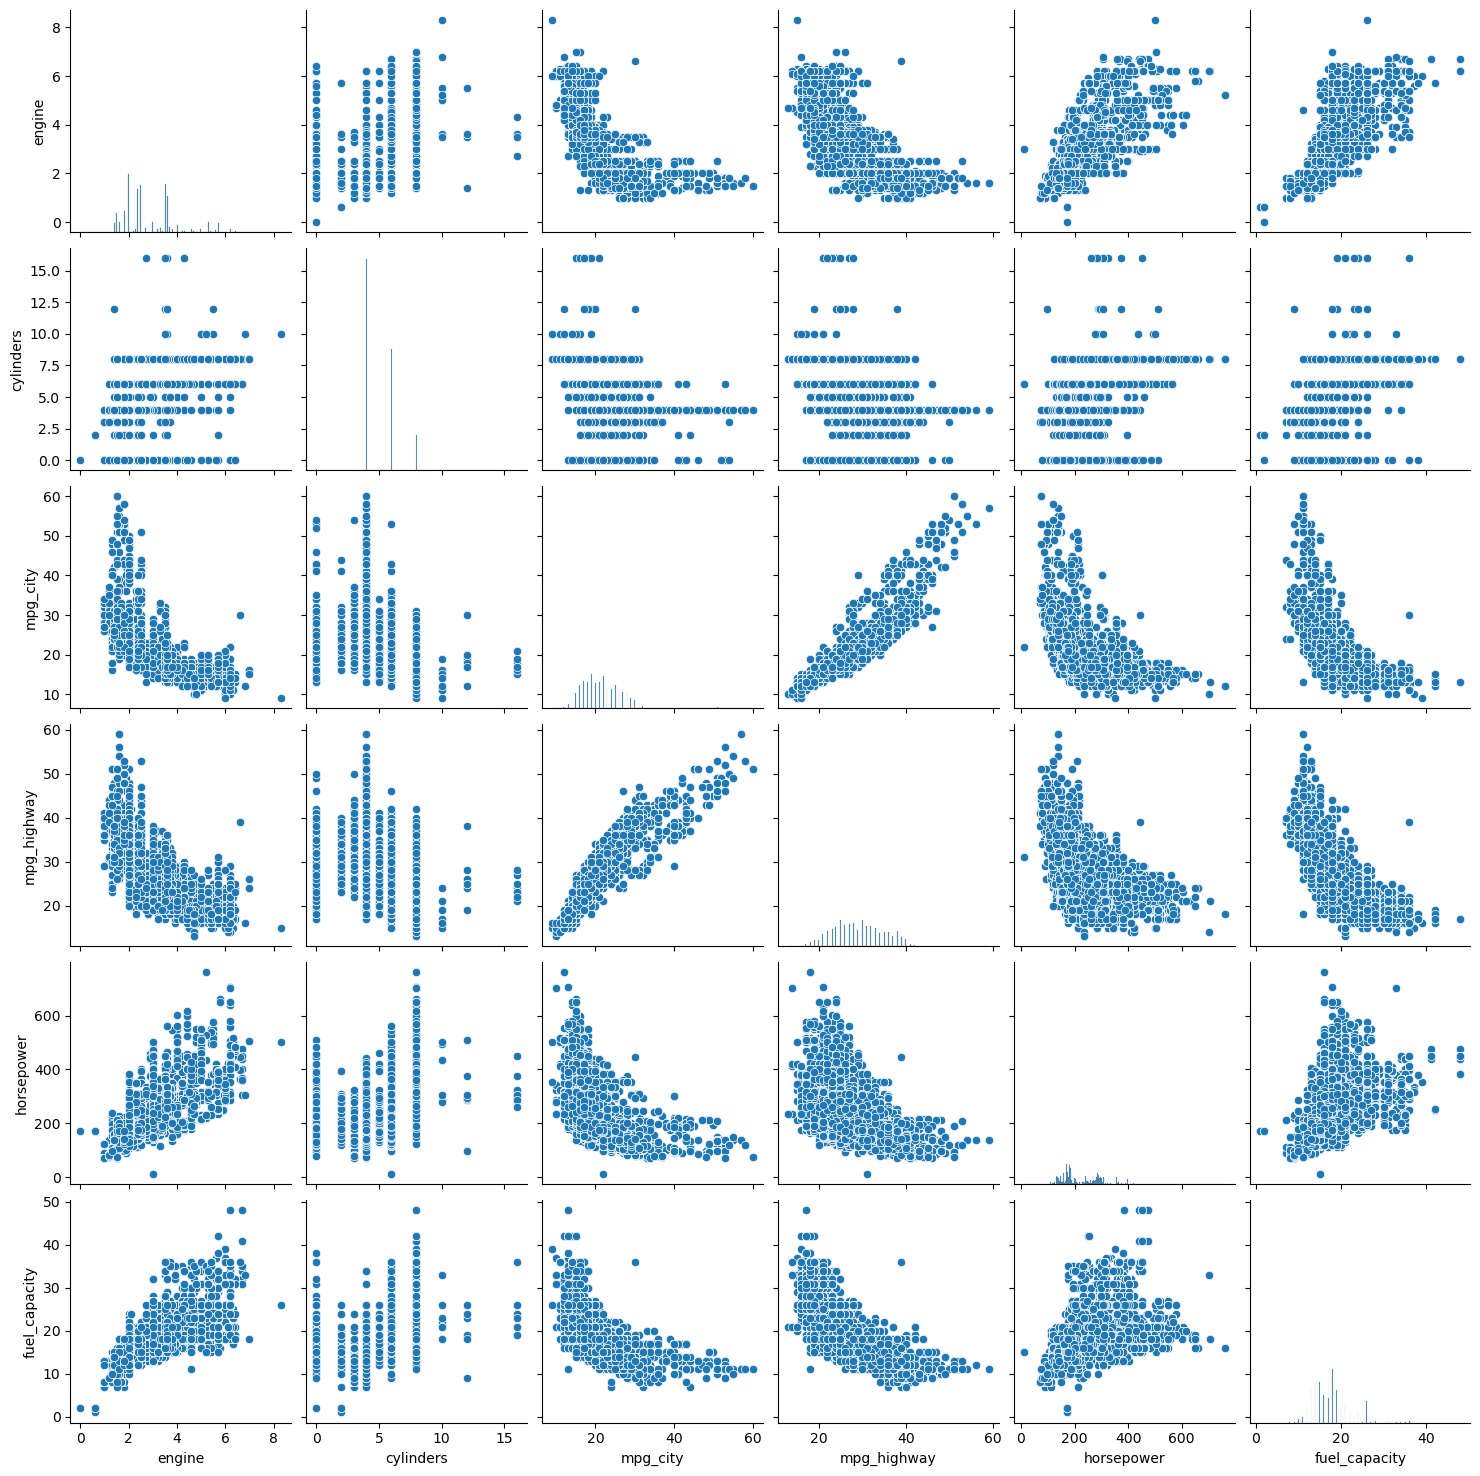

In [32]:
pair_cols = [c for c in numeric_cols.keys() if c != "model_year"]
sns.pairplot(data=long_kmax_data[pair_cols]);

Like I mentioned, there is generally a positive trend for engine/horsepower/cylinder/fuel capacity. Not always necessarily linear or homoskedastic, but an association nonetheless.

Likewise, mpg city/highway track intensely closely

Notably, these two groupings describing "engine power" (engine/horsepower/cylinders, fuel capacity is a bit conceptually different but likely tracks with size of engine due to practical engineering concerns) and "efficiency" (MPG city/highway) are negatively associated.

Below I'll use PCA to reduce these into a single value that we can plot.

In [33]:
pcs_to_form = {"engine_power": ["cylinders","engine","horsepower","fuel_capacity"], "engine_efficiency": ["mpg_city", "mpg_highway"]}
# Create new measures
for new_col, cols in pcs_to_form.items():
    data = long_kmax_data[cols].copy()
    incomplete = data.isna().any(axis=1)
    complete = ~incomplete
    long_kmax_data[new_col] = np.nan
    new_vals = PCA(n_components=1).fit_transform(data[complete])
    new_vals = StandardScaler().fit_transform(new_vals)
    long_kmax_data.loc[complete, new_col] = new_vals

In [34]:
long_kmax_data['range'] = long_kmax_data['engine_efficiency'] * long_kmax_data['fuel_capacity']

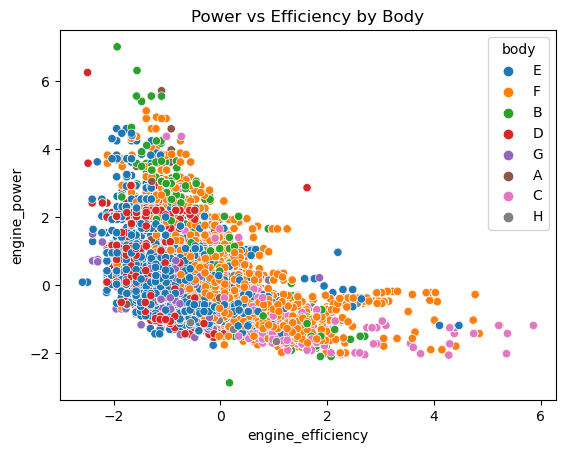

In [35]:
sns.scatterplot(data=long_kmax_data, x="engine_efficiency", y="engine_power", hue="body")
plt.title("Power vs Efficiency by Body");

In [36]:
long_kmax_data['value_midpoint'] = get_midpoint(long_kmax_data['value'])

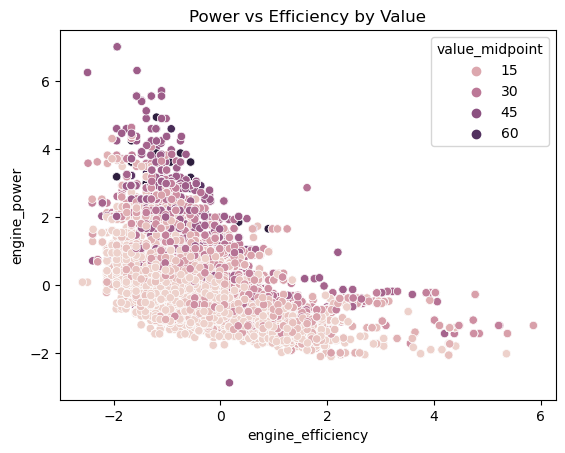

In [37]:
sns.scatterplot(data=long_kmax_data, x="engine_efficiency", y="engine_power", hue="value_midpoint")
plt.title("Power vs Efficiency by Value");

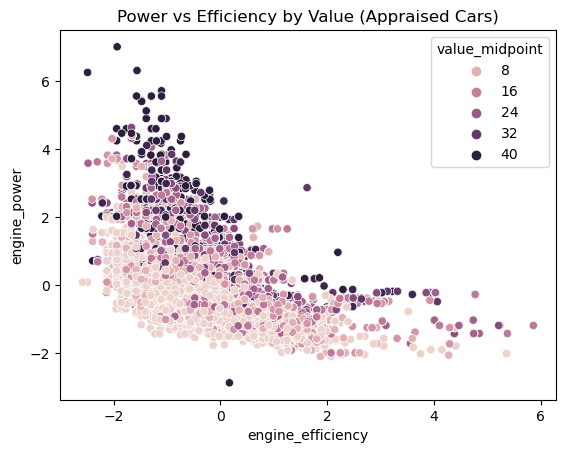

In [38]:
sns.scatterplot(data=long_kmax_data[long_kmax_data["itransaction"] == 'appraisal'], x="engine_efficiency", y="engine_power", hue="value_midpoint")
plt.title("Power vs Efficiency by Value (Appraised Cars)");

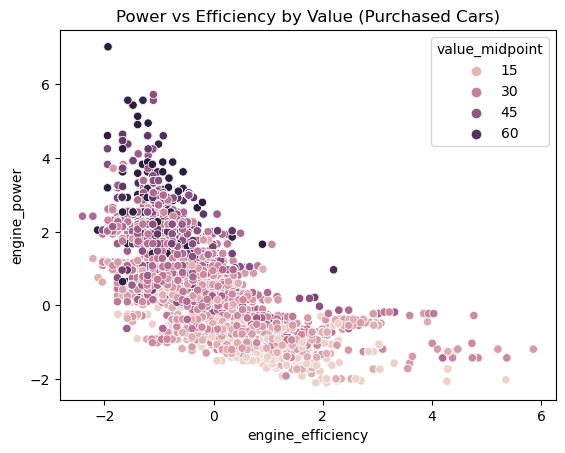

In [39]:
sns.scatterplot(data=long_kmax_data[long_kmax_data["itransaction"] == 'purchase'], x="engine_efficiency", y="engine_power", hue="value_midpoint");
plt.title("Power vs Efficiency by Value (Purchased Cars)");

Above we can see that car with a higher value tend to lie "above" the average vehicle when it comes to engine power/efficiency and vice versa for lower value.

Interestingly, the more popular body types also seem to lie above this axis more often. Since popularity/desirability and price tend to go hand-in-hand in economics, this makes sense. although budget options can be quite popular too, so this trend is not perfect. It is better than I would have guessed. These desirable cars likely retain value better, relating to why those models tended to be more popular.

### Vehicle Range
In theory the range of a vehicle is solely a product of its fuel efficiency (MPG) and fuel capacity. Since we just looked at fuel efficiency, let's see how this behaves if we use it instead of efficiency.

In [40]:
long_kmax_data['range'] = long_kmax_data['engine_efficiency'] * long_kmax_data['fuel_capacity']

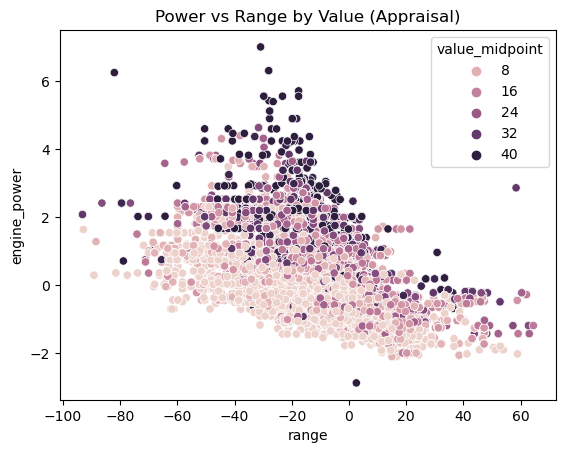

In [41]:
sns.scatterplot(data=long_kmax_data[long_kmax_data["itransaction"]=="appraisal"], x="range", y="engine_power", hue="value_midpoint")
plt.title("Power vs Range by Value (Appraisal)");

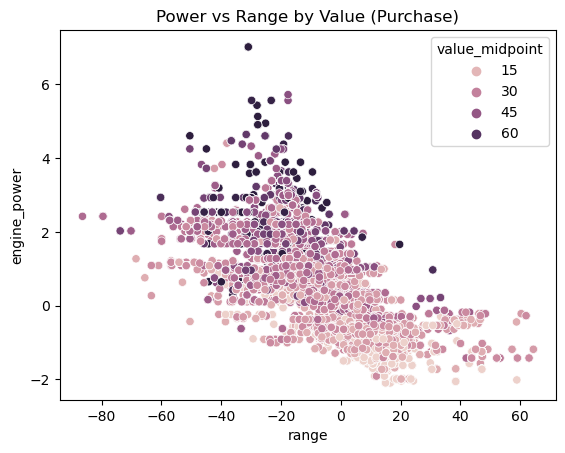

In [42]:
sns.scatterplot(data=long_kmax_data[long_kmax_data["itransaction"]=="purchase"], x="range", y="engine_power", hue="value_midpoint")
plt.title("Power vs Range by Value (Purchase)");

Not only does this simplify the overall relationship between power and efficiency quite nicely, but we can tell that different body types are a bit different. This makes sense, since the relationship between power and efficiency of, for instanc SUVs is not likely to be the same as for a Sedan.

## Trim Type

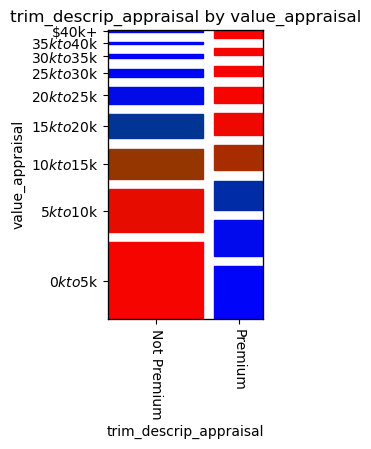

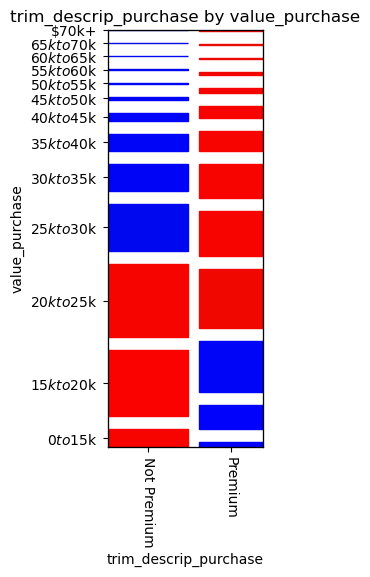

In [43]:
generate_mosaic_plot(kmax_data,  "trim_descrip_appraisal", "value_appraisal", scale=(3,1.25))
generate_mosaic_plot(kmax_data,  "trim_descrip_purchase", "value_purchase", scale=(3,1.25))

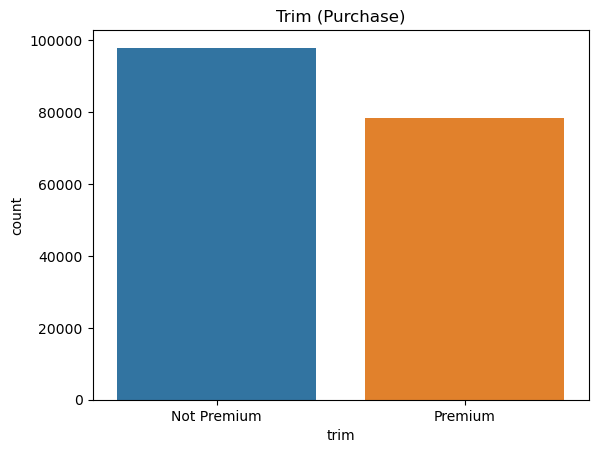

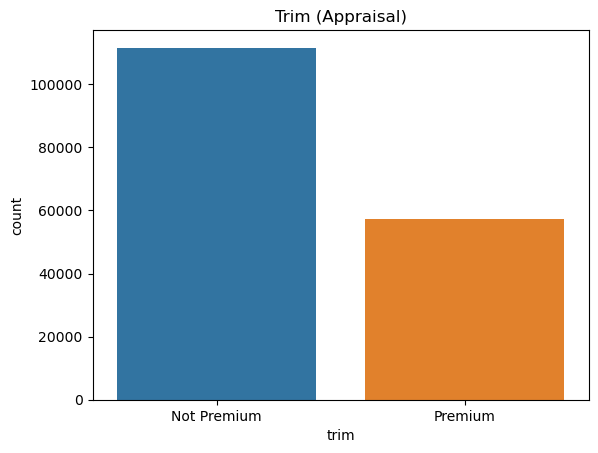

In [44]:
for i in ["purchase", "appraisal"]:
    trim_freqs = kmax_data[f"trim_descrip_{i}"].value_counts(sort=True).reset_index().rename(columns={"index":"trim",f"trim_descrip_{i}":"count"})
    sns.barplot(y="count", x="trim", data=trim_freqs)
    plt.title(f"Trim ({i.capitalize()})")
    plt.show()
    plt.close()

Unsurprisingly, premium trim is associated with higher values and non-premium with lower values. We also see that premium trim is bit more common as a fraction of 

## Color
Lastly, we'll take a look at color.
I'd be quite surprised if color 

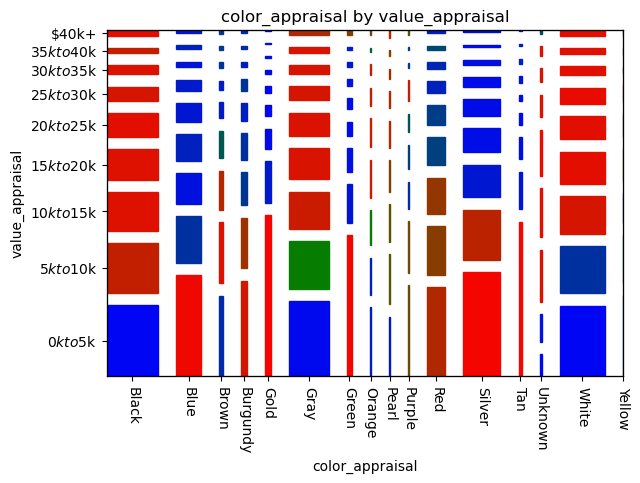

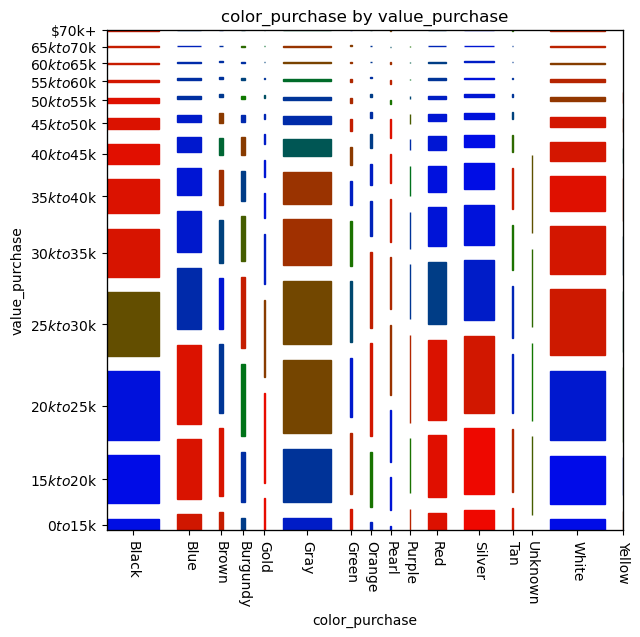

In [45]:
generate_mosaic_plot(kmax_data,  "color_appraisal", "value_appraisal", scale=(1.25,1.5))
generate_mosaic_plot(kmax_data,  "color_purchase", "value_purchase", scale=(1.25,1.5))

Notable, greyscale (white, black, and gray() cars are tend to have higher values than cars of other colors.